In [2]:
#!pip install colorlover

# Objective
Starcraft II is an incomplete information multiplayer real-time strategy game that centers around gathering resources to build units and defeat an opponent. Players of this game generally play in an online ladder that places players into different leagues based on their performance against other players using a ranking system similar to ELO in chess. Unlike in chess, players must race against their opponent to execute their strategy, while at the same time gathering information on their opponent and defending their attacks.

When joining the current ladder system, players are required to play 10 placement matches in order to find their leagues. However, this tends to under estimate their skills and takes many games for players to arrive at the correct placement. During this adjustment period, it could give other players who are correctly placed bad experiences by being completely outmatched.

The objective of this project is to predict the league placement of a Starcraft II player by only using the information contained inside a replay (meaning that player specific haracteristics as Age, HoursPlayed etc should be removed)). The real-time nature of the game allows us to differentiate players through the speed and efficiency of their in game actions. This is in an attepmt to reduce the time taken to arrive at the correct placement.

arget Feature
The target feature is the league index which is numbers 1-8 representing Bronze, Silver, Gold, Platinum, Diamond, Master, Grandmaster, Professional leagues. However, it was found that we have very small proportions of Bronze, Grandmaster and Professional league players in the dataset. In order to prevent this imbalance from impacting the predictive performance of our models, these leagues will be rolled into the leagues closest to them, resulting in the following index:

Beginenr

Bronze-Silver-Gold

Platinum

Diamond

Master-Grandmaster-Professional

The objective being to accurately place a player into one of these leagues just by using data that can be automatically mined from a replay.

# Methodology

First, the dataset from phase 1 will be transformed to suit our analysis. This includes reencoding the target feature to balance out its populations, as well as dropping unnecessary features and scaling the descriptive features.

The data will be randomly split with stratificationinto training and test sets with a 70:30 ratio. This results in a training set with 2336 rows and a test set with 1002 rows. Stratification is necessary to ensure that each validation set has the same proportion of target classes as in the original dataset because the population is imbalanced.

As part of the model fitting pipeline, we will be using ANOVA F-value, Mutual Information and Chi-squared methods to select the top 3, 4, 5, 6, 7, 10 or 15 (full set) of features.

We will conduct a 5-fold repeated stratified cross-validation (with 3 repeats) to fine-tune hyperparameters of each classifier using Accuracy as the performance metric. This will be done in a single pipeline along with feature selection for each model with parallel processing using "-2" cores.

Once the best model of the three has been identified, using hyperparameter search on the training data, we conduct a 10-fold repeated (3 repeats) cross-validation on the test data and perform a paired t-test to see if any performance difference is statistically significant. In addition, we compare the classifiers with respect to their precision scores, recall scores and confusion matrices on the test data.

Additionaly, we will use some heavy artillery by bringing in some deep learning approches using Keras and Pytorch

Finally, in attempt to improve results we will seek to increase number of features and compare the overall results

Let's tart with importing some libs

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
# For plot marker colours
import colorlover as cl
from sklearn import preprocessing
from sklearn.feature_selection import SelectKBest, f_classif, mutual_info_classif, chi2
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import PowerTransformer
from sklearn.model_selection import cross_val_score
from scipy import stats
from sklearn import metrics

# Reading and basic EDA

In [4]:
sc = pd.read_csv("SkillCraft1_Dataset.csv")
sc.head()

GameID  LeagueIndex Age HoursPerWeek TotalHours       APM  SelectByHotkeys  \
0      52            5  27           10       3000  143.7180         0.003515   
1      55            5  23           10       5000  129.2322         0.003304   
2      56            4  30           10        200   69.9612         0.001101   
3      57            3  19           20        400  107.6016         0.001034   
4      58            3  32           10        500  122.8908         0.001136   

   AssignToHotkeys  UniqueHotkeys  MinimapAttacks  MinimapRightClicks  \
0         0.000220              7        0.000110            0.000392   
1         0.000259              4        0.000294            0.000432   
2         0.000336              4        0.000294            0.000461   
3         0.000213              1        0.000053            0.000543   
4         0.000327              2        0.000000            0.001329   

   NumberOfPACs  GapBetweenPACs  ActionLatency  ActionsInPAC  \
0      0.004849         32.6677        40.8673        4.7508   
1      0.004307         32.9194        42.3454        4.8434   
2      0.002926         44.6475        75.3548        4.0430   
3      0.003783         29.2203        53.7352        4.9155   
4      0.002368         22.6885        62.0813        9.3740   

   TotalMapExplored  WorkersMade  UniqueUnitsMade  ComplexUnitsMade  \
0                28     0.001397                6               0.0   
1                22     0.001194                5               0.0   
2                22     0.000745                6               0.0   
3                19     0.000426                7               0.0   
4                15     0.001174                4               0.0   

   ComplexAbilitiesUsed  
0              0.000000  
1              0.000208  
2              0.000189  
3              0.000384  
4              0.000019

In [5]:
print(f"Dimension of the data set is{sc.shape}\n")
print(f"Data Types are:")
print(sc.dtypes)

Dimension of the data set is(3395, 20)

Data Types are:
GameID                    int64
LeagueIndex               int64
Age                      object
HoursPerWeek             object
TotalHours               object
APM                     float64
SelectByHotkeys         float64
AssignToHotkeys         float64
UniqueHotkeys             int64
MinimapAttacks          float64
MinimapRightClicks      float64
NumberOfPACs            float64
GapBetweenPACs          float64
ActionLatency           float64
ActionsInPAC            float64
TotalMapExplored          int64
WorkersMade             float64
UniqueUnitsMade           int64
ComplexUnitsMade        float64
ComplexAbilitiesUsed    float64
dtype: object


In [6]:
sc.drop(columns=["Age", "HoursPerWeek", "TotalHours"], inplace=True)

In [7]:
print("Number of missing value for each feature:")
print(sc.isnull().sum())

Number of missing value for each feature:
GameID                  0
LeagueIndex             0
APM                     0
SelectByHotkeys         0
AssignToHotkeys         0
UniqueHotkeys           0
MinimapAttacks          0
MinimapRightClicks      0
NumberOfPACs            0
GapBetweenPACs          0
ActionLatency           0
ActionsInPAC            0
TotalMapExplored        0
WorkersMade             0
UniqueUnitsMade         0
ComplexUnitsMade        0
ComplexAbilitiesUsed    0
dtype: int64


In [8]:
sc.describe()

GameID  LeagueIndex          APM  SelectByHotkeys  \
count   3395.000000  3395.000000  3395.000000      3395.000000   
mean    4805.012371     4.184094   117.046947         0.004299   
std     2719.944851     1.517327    51.945291         0.005284   
min       52.000000     1.000000    22.059600         0.000000   
25%     2464.500000     3.000000    79.900200         0.001258   
50%     4874.000000     4.000000   108.010200         0.002500   
75%     7108.500000     5.000000   142.790400         0.005133   
max    10095.000000     8.000000   389.831400         0.043088   

       AssignToHotkeys  UniqueHotkeys  MinimapAttacks  MinimapRightClicks  \
count      3395.000000    3395.000000     3395.000000         3395.000000   
mean          0.000374       4.364654        0.000098            0.000387   
std           0.000225       2.360333        0.000166            0.000377   
min           0.000000       0.000000        0.000000            0.000000   
25%           0.000204       3.000000        0.000000            0.000140   
50%           0.000353       4.000000        0.000040            0.000281   
75%           0.000499       6.000000        0.000119            0.000514   
max           0.001752      10.000000        0.003019            0.004041   

       NumberOfPACs  GapBetweenPACs  ActionLatency  ActionsInPAC  \
count   3395.000000     3395.000000    3395.000000   3395.000000   
mean       0.003463       40.361562      63.739403      5.272988   
std        0.000992       17.153570      19.238869      1.494835   
min        0.000679        6.666700      24.093600      2.038900   
25%        0.002754       28.957750      50.446600      4.272850   
50%        0.003395       36.723500      60.931800      5.095500   
75%        0.004027       48.290500      73.681300      6.033600   
max        0.007971      237.142900     176.372100     18.558100   

       TotalMapExplored  WorkersMade  UniqueUnitsMade  ComplexUnitsMade  \
count       3395.000000  3395.000000      3395.000000       3395.000000   
mean          22.131664     0.001032         6.534021          0.000059   
std            7.431719     0.000519         1.857697          0.000111   
min            5.000000     0.000077         2.000000          0.000000   
25%           17.000000     0.000683         5.000000          0.000000   
50%           22.000000     0.000905         6.000000          0.000000   
75%           27.000000     0.001259         8.000000          0.000086   
max           58.000000     0.005149        13.000000          0.000902   

       ComplexAbilitiesUsed  
count           3395.000000  
mean               0.000142  
std                0.000265  
min                0.000000  
25%                0.000000  
50%                0.000020  
75%                0.000181  
max                0.003084

In [11]:
sc['LeagueIndex'].unique()

array([5, 4, 3, 2, 1, 7, 6, 8])

In [12]:
%matplotlib inline

# Name the leagues
league_lbls = ["Beginner","Bronze","Silver","Gold","Platinum","Diamond","Master","Grandmaster"]
league_indexs = sc["LeagueIndex"].unique()
league_indexs.sort()
league_lbls_dict = dict()
for i, ind in enumerate(league_indexs):
    league_lbls_dict[ind] = league_lbls[i]
league_labeled = sc["LeagueIndex"].replace(league_lbls_dict)


def clrgb_to_hex(rgb):
    rgb = re.search("\(([^\)]+)\)", rgb).group(1).split(",")
    hex_clr = "#"
    for n in rgb:
        val = hex(int(n))[2:]
        if len(val)<2:
            val = "0"+val
        hex_clr+=val
    return hex_clr


# Define league colours for consistency
league_colours_raw = cl.scales['8']['qual']['Paired']
league_colours = []
for i, clr in enumerate(league_colours_raw):
    league_colours.append(clrgb_to_hex(league_colours_raw[i]))

league_colours_dict = dict()
for i, lbl in enumerate(league_lbls):
    league_colours_dict[lbl] = league_colours[i]
    
    
def box_hist_plot(x, title, w, h):
    fig, (ax_box, ax_hist)= plt.subplots(2, sharex=True,gridspec_kw={"height_ratios": (.15,.85)})
    fig.set_size_inches(w, h)
    
    ax_box.set_xlim(0,x.max())
    ax_hist.set_xlim(0,x.max())
    
    sns.boxplot(x, ax=ax_box)
    sns.distplot(x, ax=ax_hist)
    ax_box.set(yticks=[])
    
    sns.despine(ax=ax_hist)
    sns.despine(ax=ax_box, left=True)
    ax_box.set_title(title)
    ax_hist.set_title(None)
    plt.show()
    
def violin_plot(y, title, w, h):
    plt.figure(figsize=(w, h))
    ax1 = sns.violinplot(x=league_labeled, y=y, palette=league_colours_dict, order=league_lbls)
    ax1.set_ylim(0,)
    ax1.set(xlabel='League')
    plt.title(title)
    plt.show()
    
def auto_plot(feature, fig_num):
    box_hist_plot(sc[feature], f"Figure {fig_num}: {feature} Distribution", 11, 8)
    violin_plot(sc[feature], f"Figure {fig_num+1}: {feature} by League", 11, 8)

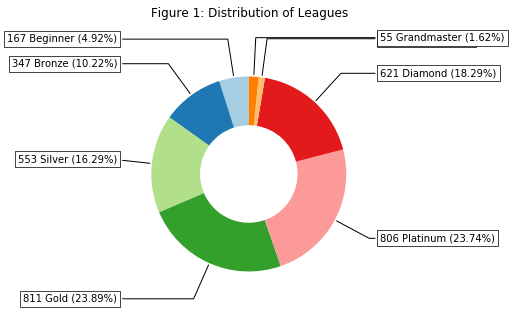

In [13]:
def league_dist():
    global fig_count
    
    #labels
    lab = league_lbls
    #values: counts for each category
    val = sc["LeagueIndex"].value_counts().sort_index().values.tolist()
    pct = [x/sum(val)for x in val]
    
    fig1, ax1 = plt.subplots()
    #ax1.pie(val, labels=lab, autopct='%1.2f%%', pctdistance=0.8,shadow=True, startangle=90)
    
    wedges, texts = ax1.pie(pct, wedgeprops=dict(width=0.5), startangle=90, colors=league_colours)
    ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
    
    bbox_props = dict(boxstyle="square,pad=0.3", fc="w", ec="k", lw=0.72)
    kw = dict(xycoords='data', textcoords='data', arrowprops=dict(arrowstyle="-"),
          bbox=bbox_props, zorder=0, va="center")
    
    for i, p in enumerate(wedges):
        ang = (p.theta2 - p.theta1)/2. + p.theta1
        y = np.sin(np.deg2rad(ang))
        x = np.cos(np.deg2rad(ang))
        horizontalalignment = {-1: "right", 1: "left"}[int(np.sign(x))]
        connectionstyle = "angle,angleA=0,angleB={}".format(ang)
        kw["arrowprops"].update({"connectionstyle": connectionstyle})
        ax1.annotate(f"{val[i]} {league_lbls[i]} ({pct[i]*100:.2f}%)", xy=(x, y), xytext=(1.35*np.sign(x), 1.4*y), horizontalalignment=horizontalalignment, **kw)
    
    ax1.set_title("Figure 1: Distribution of Leagues", y=1.2)
    
league_dist()

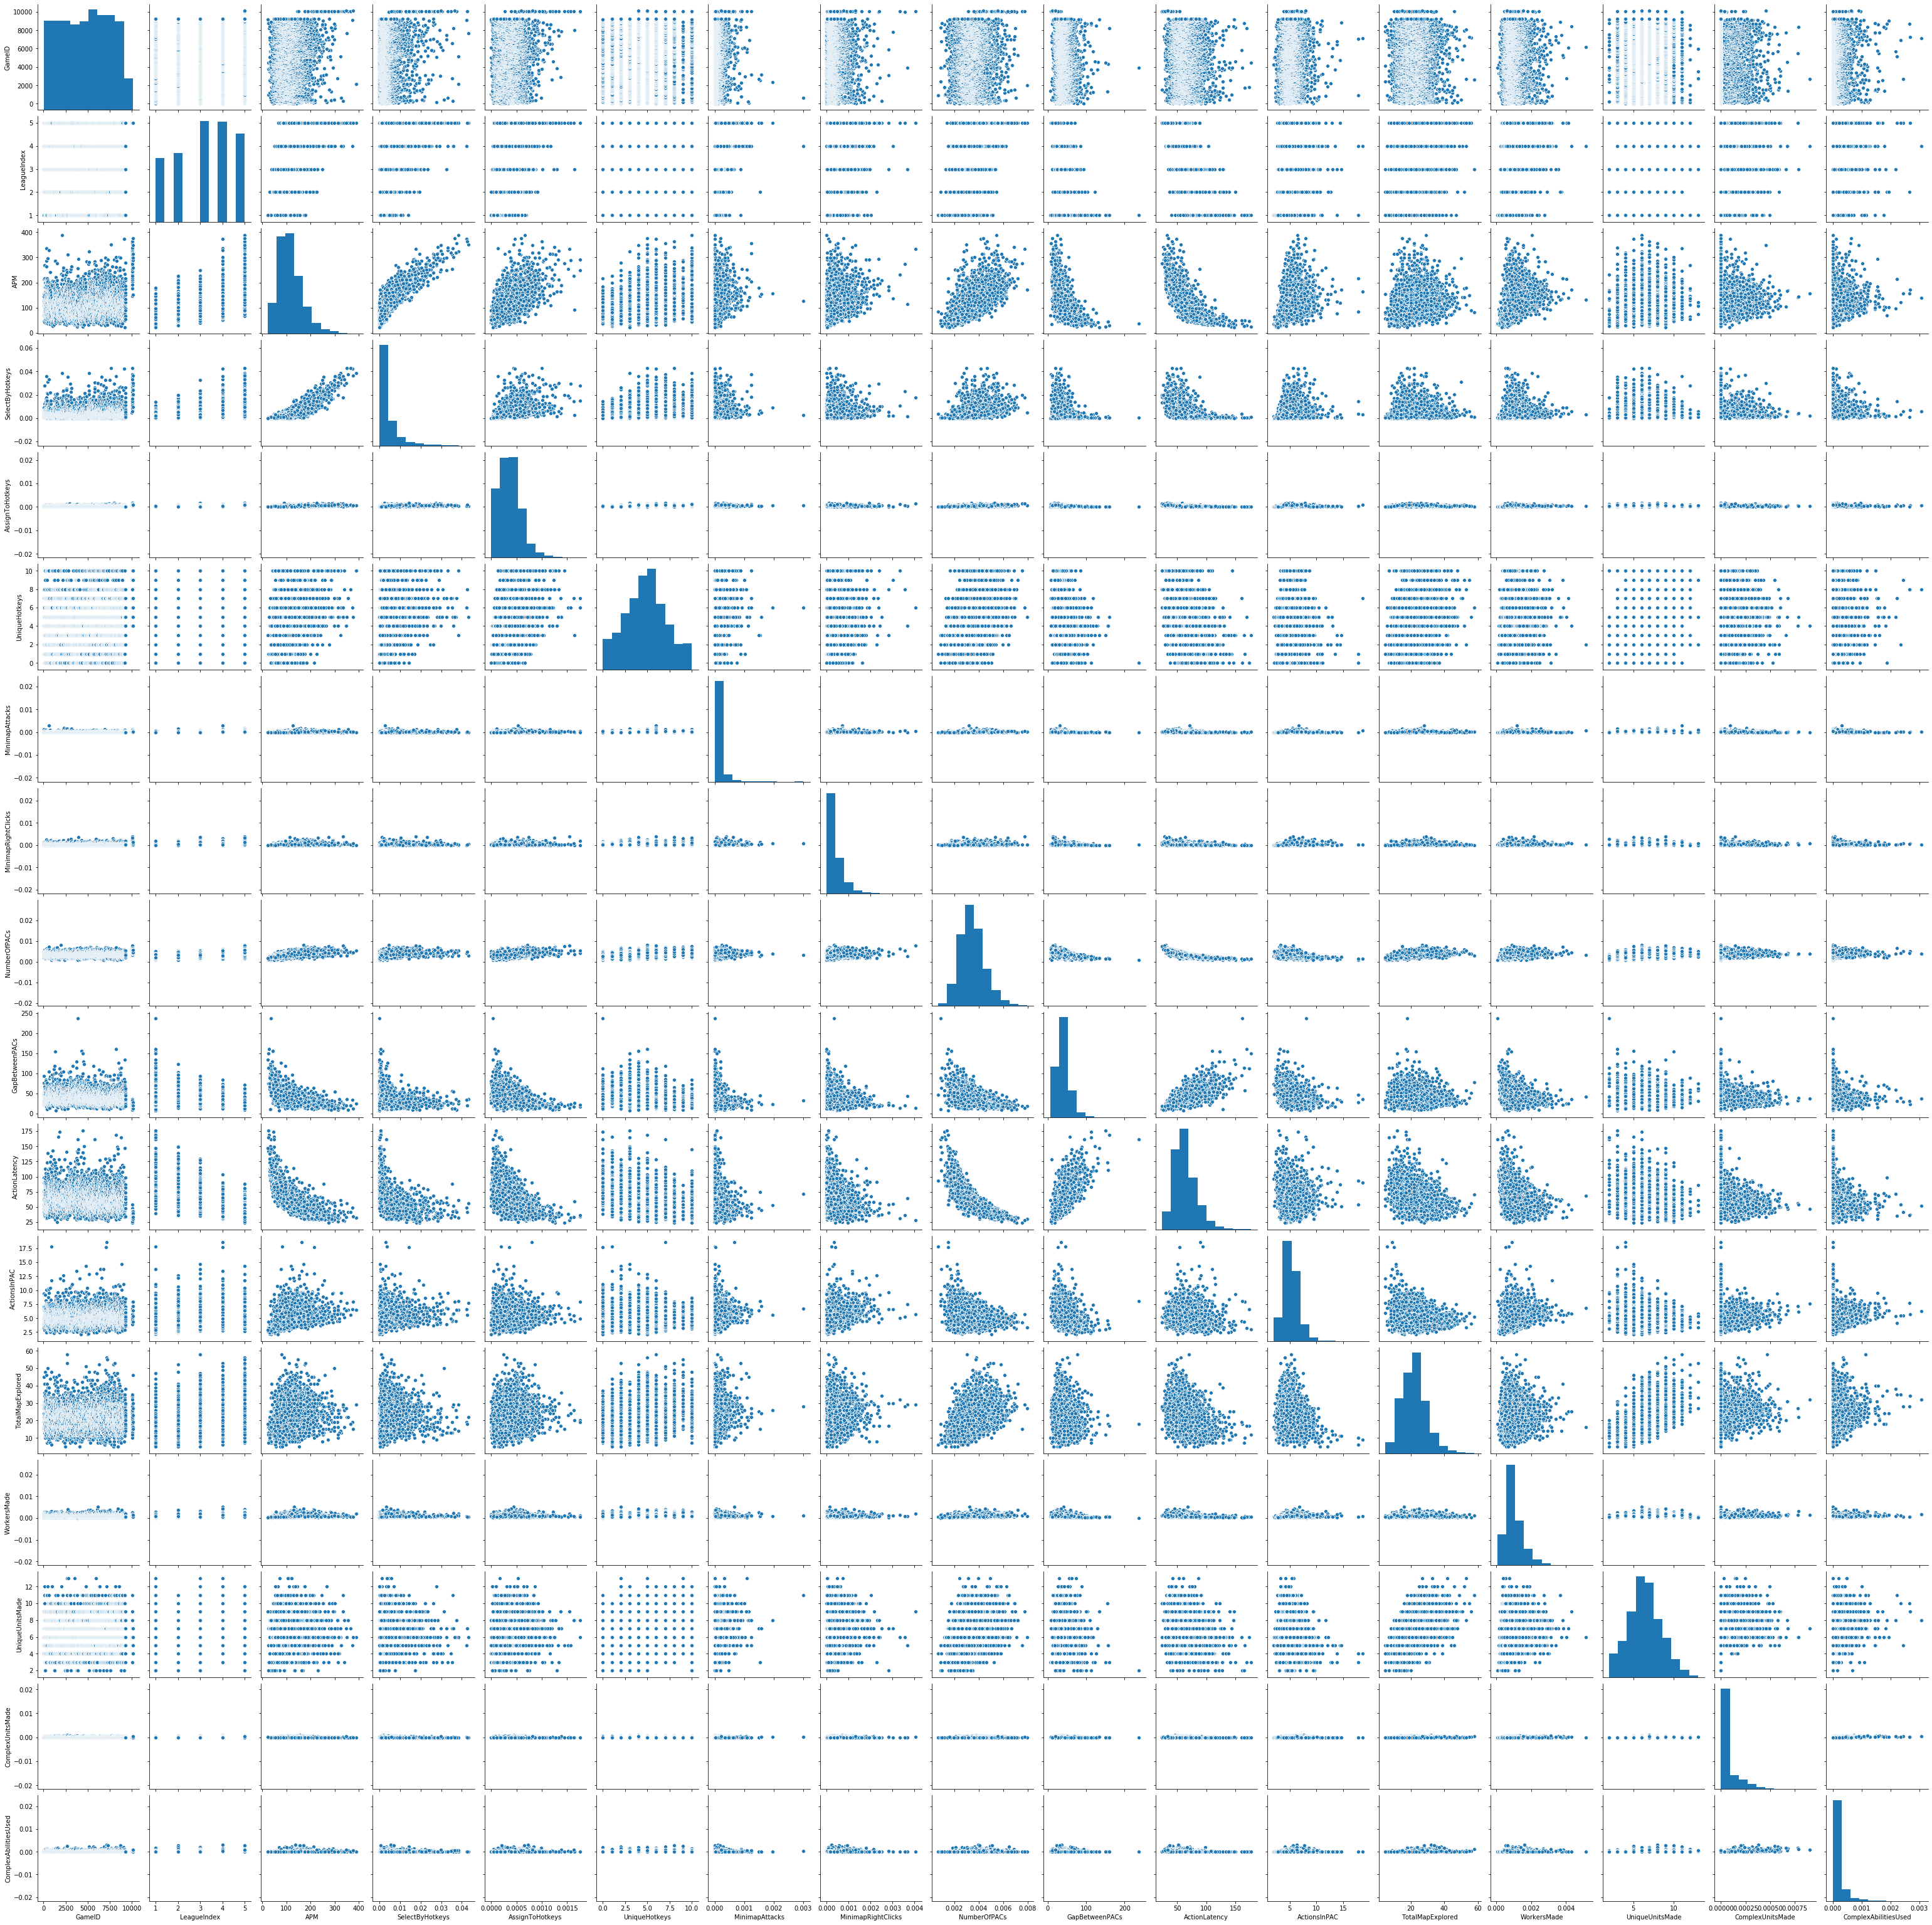

In [107]:
sns.pairplot(sc);

/Users/pavelgolubev/opt/anaconda3/lib/python3.7/site-packages/seaborn/axisgrid.py:243: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


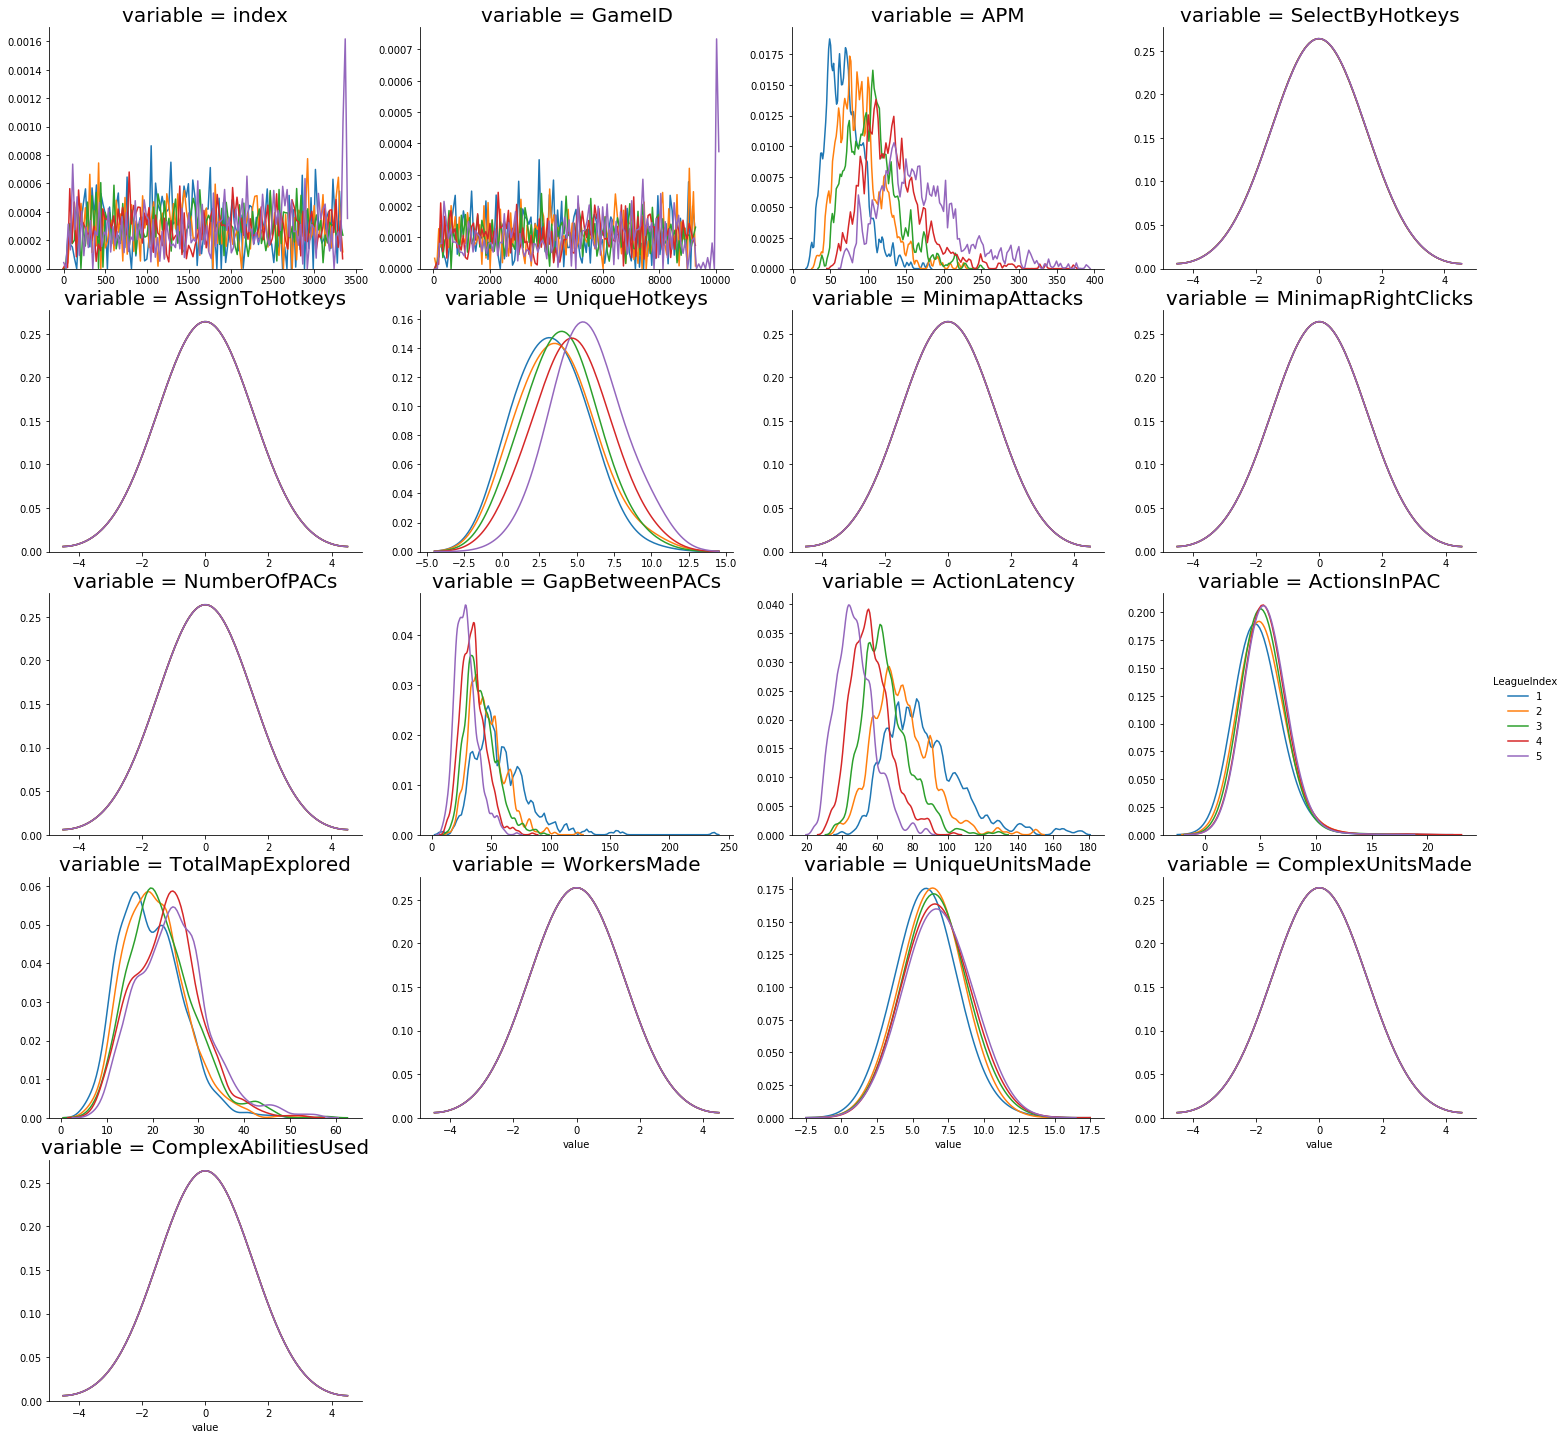

In [420]:
target_var = "LeagueIndex"
melt_df = pd.melt(sc, id_vars=target_var)
grid = sns.FacetGrid(melt_df,col="variable", hue=target_var, col_wrap=4 , size=4.0, aspect=1.3, sharex=False, sharey=False)
grid.map(sns.kdeplot, "value", bw = 1.5)
grid.set_titles(size=20)
grid.add_legend();
plt.show()

There are some interesting statistcis seen in pairpolots, we can probably identify some patterns which characterize different leagues players. Let's confirm it in the next step bu building distribution plots one by one, as well as violin league-focused plots for every feature

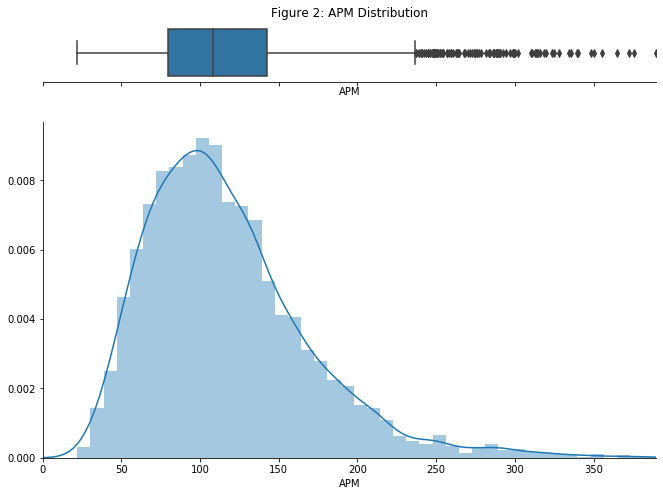

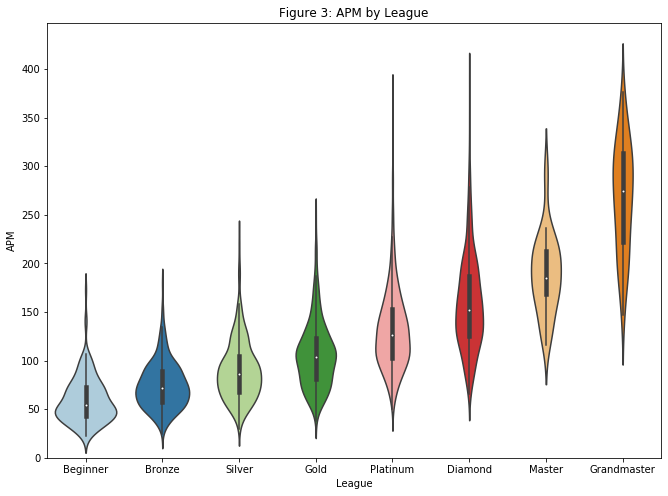

In [14]:
auto_plot("APM",2)

In figure 2, the mean of Action Per Minutes (APM) is about 100, which is what I would expect from an average player. The positive skew generally comes from 2 sources:

Good players being able to perform much more effective actions than the average player.

A player repeatedly performing the same actions in quick succession that do not contribute to the outcome of the game.

Point number 2 can be a source of noise which lowers the reliability of this feature. However the proportion of players that would play like this is likely to be small as it takes a lot of effort while potentially negatively impacting the players ability to play the game.

In figure 3, there is an upward trend in APM as the league increases. However, there is fair bit of overlap between the leagues.

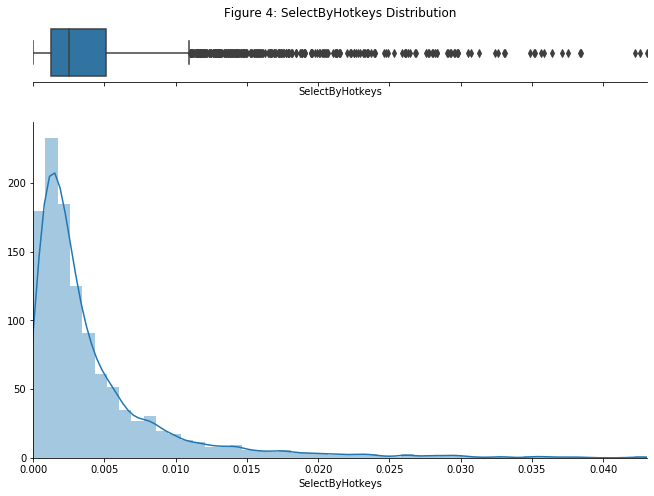

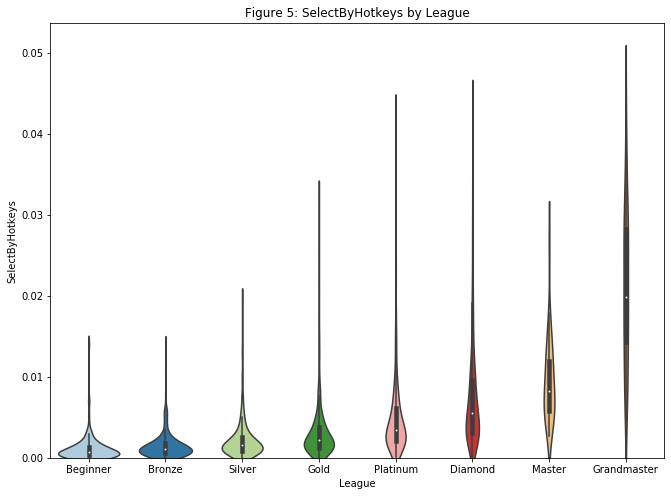

In [15]:
auto_plot("SelectByHotkeys",4)

In figure 4, a large proportion of players don't use selection by hotkeys very much, as it is likely more intuitive to select units on the screen using a mouse.

As games get more competitive, efficiency in actions become more important. Selecting by hotkeys while requiring continous maintenance throughout the game, is much faster and allows the player to not only select units anywhere on the map, but also allows instantaneous movement of the player camera to show their selected units. Unsurprisingly, hotkey usage goes up as the league improves, with a relatively large spike in professional games in figure 5.

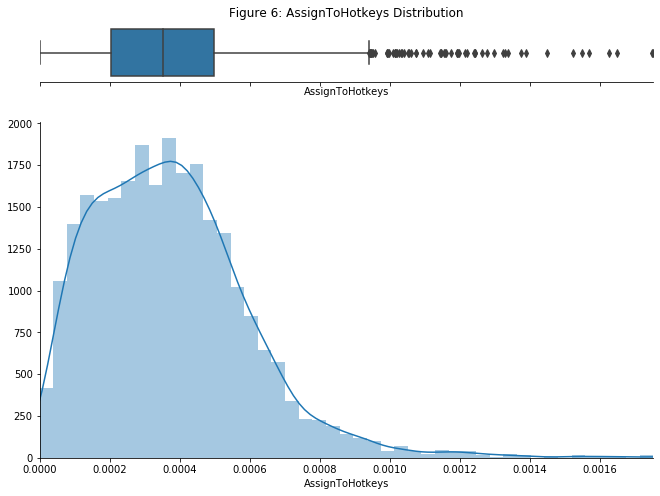

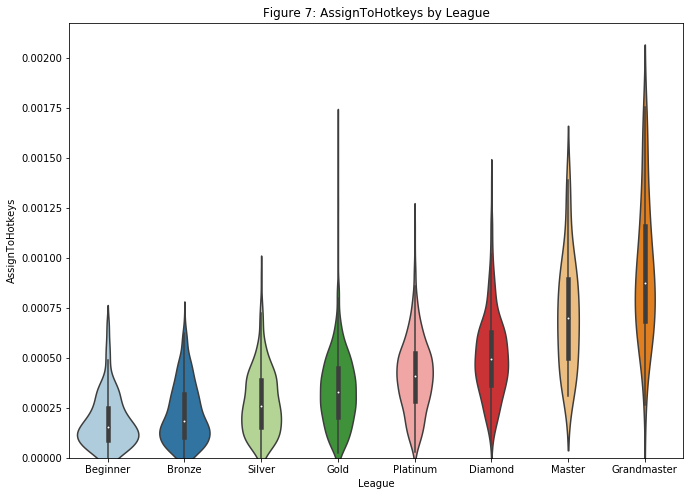

In [16]:
auto_plot("AssignToHotkeys",6)

Figures 6 and 7 show that the assignments of hotkeys are generally more balanced between the leagues, however this also tells us that proportionally many people are aware of hotkeys, and go through the setup process in game, but then do not use actually use them as much for selection.

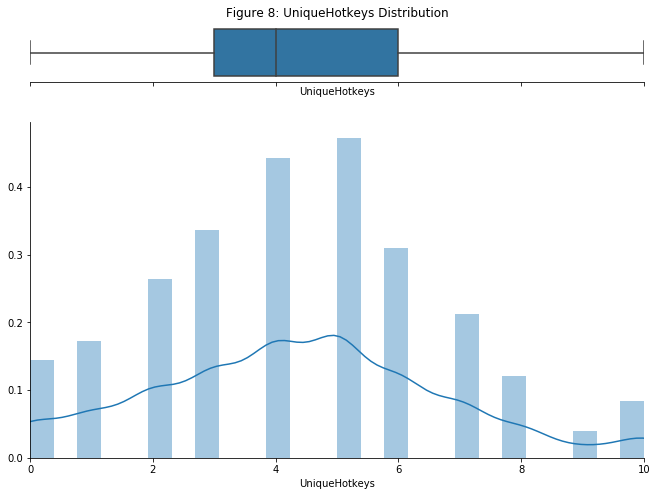

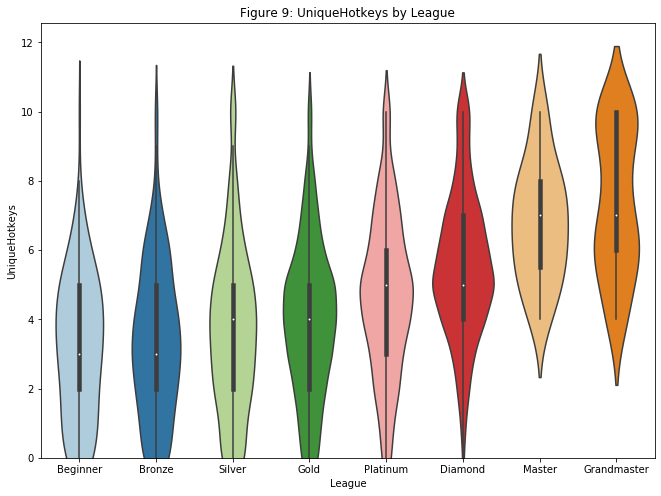

In [17]:
auto_plot("UniqueHotkeys",8)

With a maximum of 10 assignable hotkeys, figure 8 shows a fairly reasonable distribution of unique hotkey use with a mean of 4. Using more than 4 or 5 unique hotkeys takes practice and muscle memory as the movements require the player to move their hand across the keyboard using the number keys 1 to 0 without looking down in combination with other modifier keys to maximize efficiency.

There is actually an interesting step up of 1 unique hotkey used per timestamp per every 2 leagues in figure 9. But this also makes sense remembering the discussion in the section on SelectByHotkeys.

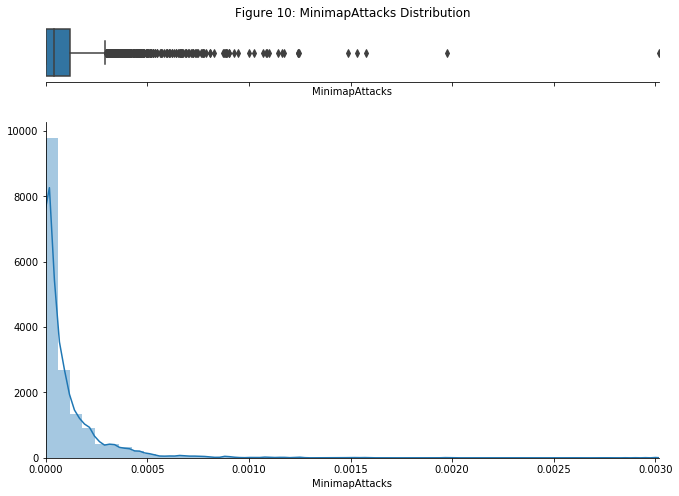

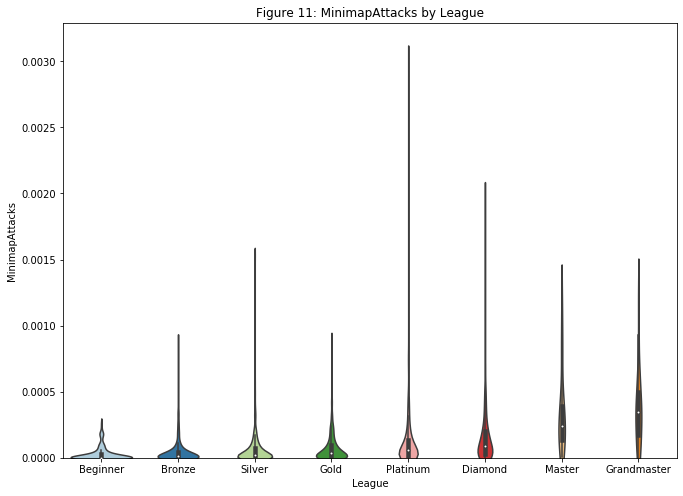

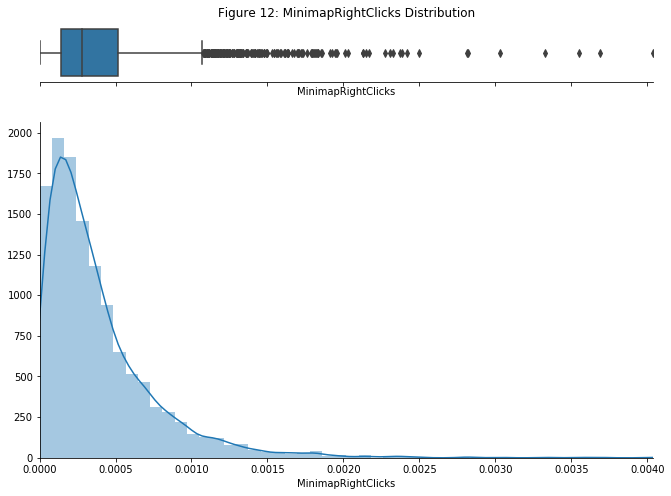

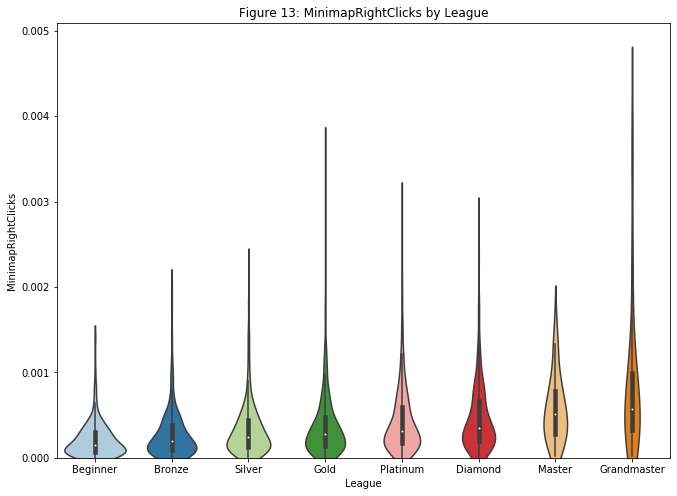

In [18]:
auto_plot("MinimapAttacks",10)
auto_plot("MinimapRightClicks",12)

Figure 11 shows that minimap attacks are very few and far between in a game, and in a lot of cases players don't even use it. There are many ways to perform attacks and the usage of the minimap can be a stylistic choice for a lot of players. However, we do still see a trend upward in use as the league improves, as players multitask more and improve the efficiency of their actions by using all the tools available to them.

The logic behind this MinimapRightClicks is similar to that of MinimapAttacks, however this is used more in general likely because the action is easier to perform.

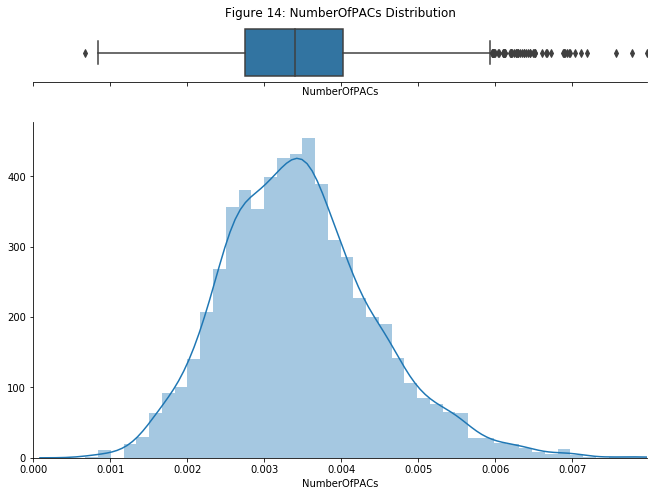

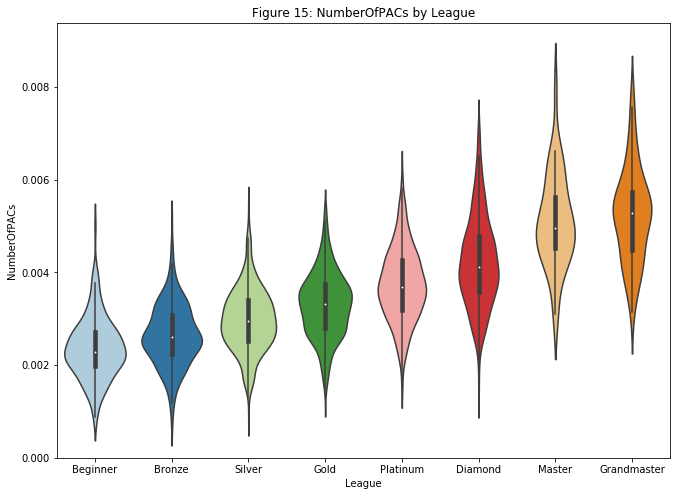

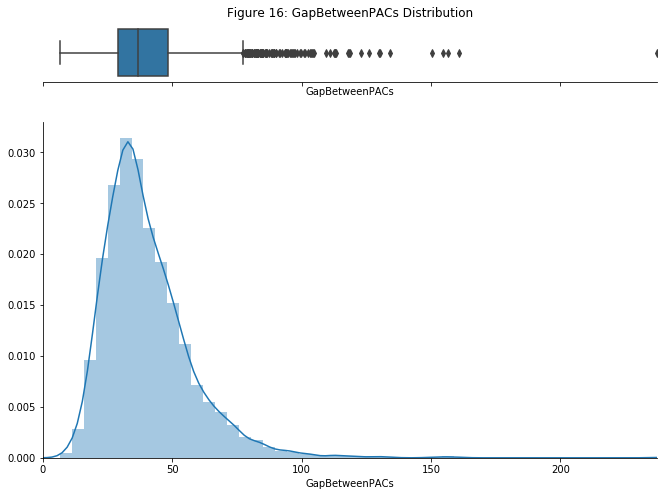

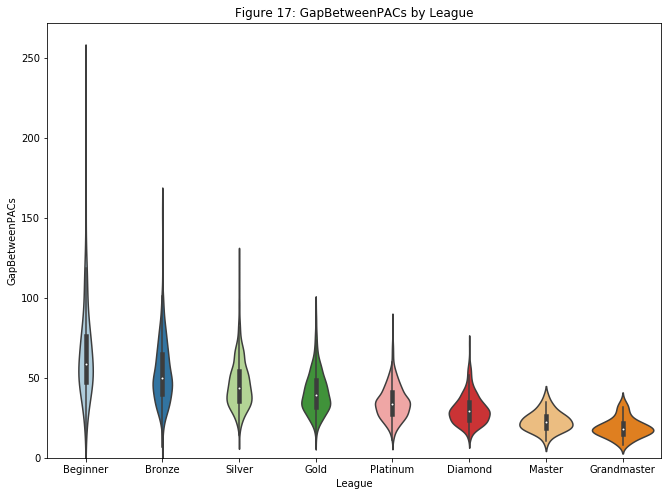

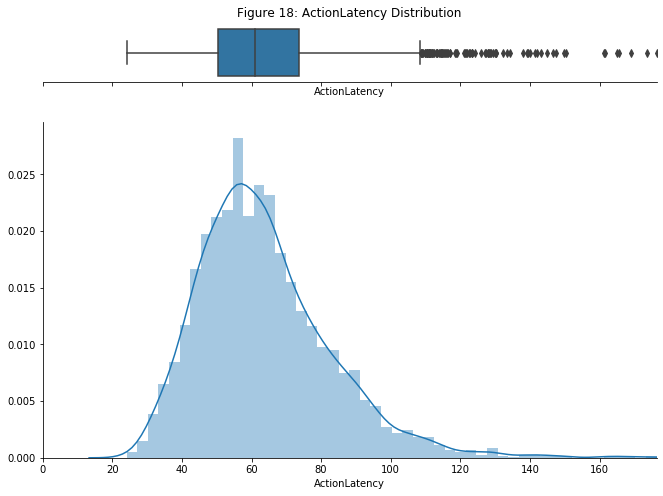

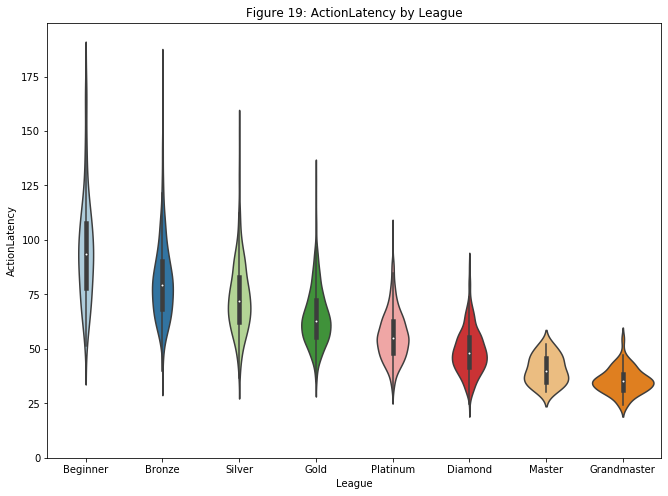

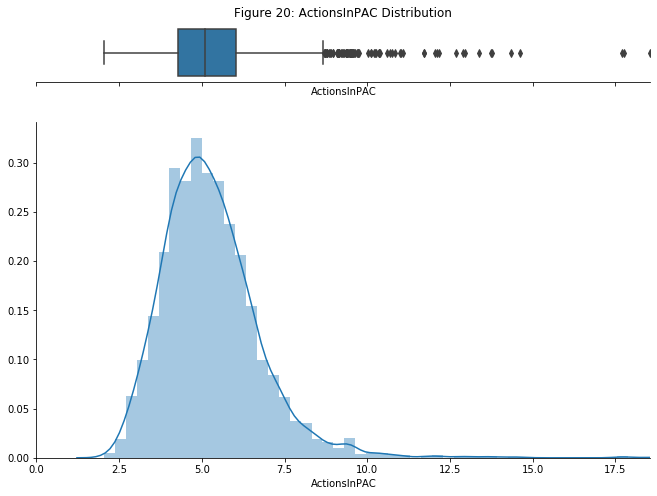

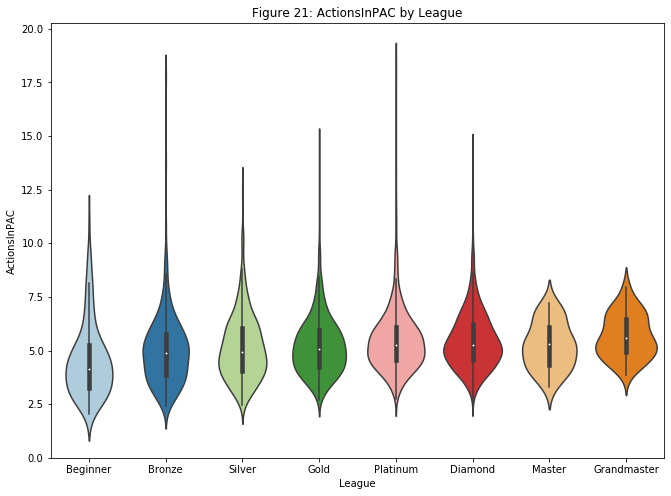

In [19]:
auto_plot("NumberOfPACs",14)
auto_plot("GapBetweenPACs",16)
auto_plot("ActionLatency",18)
auto_plot("ActionsInPAC",20)

These 3 features essentially show us the performance values for each stage in a PAC.

Similar to other activities which require fast reaction time, the more highly ranked players perceive events and take action more quickly. NumberOfPACs, GapBetweenPACs and ActionLatency improve significantly as the league improves. These feature essentially quantifies the players ability to multitask. ActionsInPAC don't change very much between leagues. When NumberOfPACs are taken into account, ActionsInPAC don't matter as much as long as players have more PACs and those actions are efficiently used.

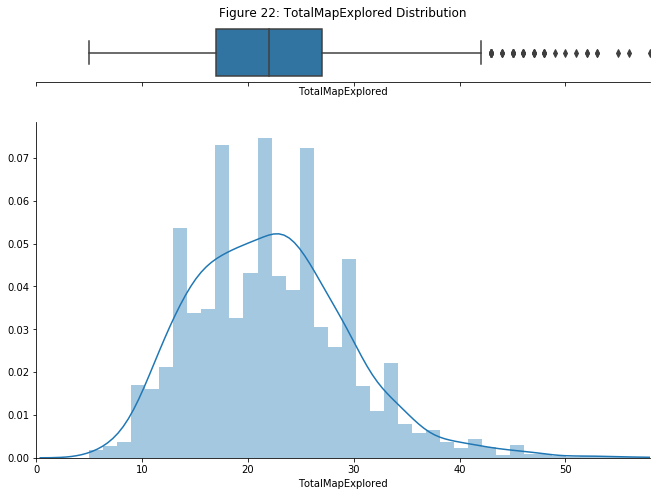

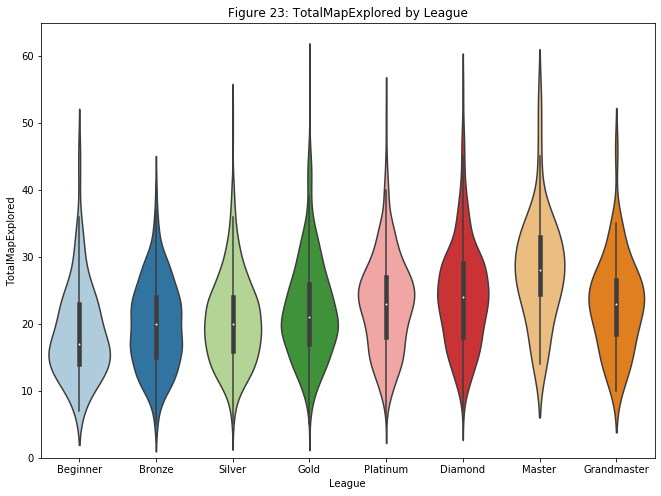

In [20]:
auto_plot("TotalMapExplored",22)

This feature does not seem to provide much information regarding the target feature. This is also quite unreliable as the amount of the map that is explored by a player can vary wildly depending on the design of the map, was well as the type of strategy the player employs.

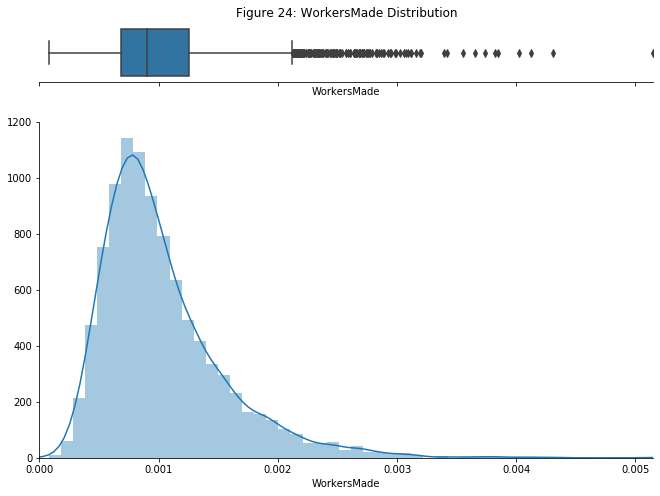

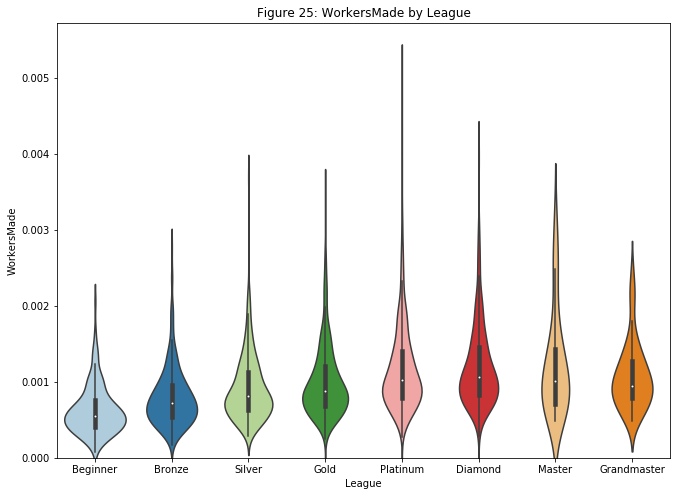

In [21]:
auto_plot("WorkersMade",24)

This feature also does not seem to provide much information regarding the target feature. It is heavily dependent on type of strategies the both players employs as well as game length. There is a balance that must be struck between using resources to create workers or improving the players army, often once a certain number of workers are created, no more will be made for the rest of the game. It can be argued that this can be used to differentiate very weak players from average or better players, but I doubt it will be very helpful in the context of this notebook.

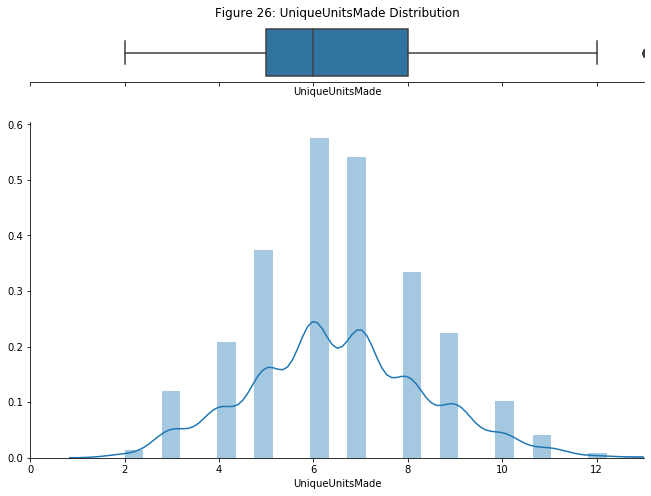

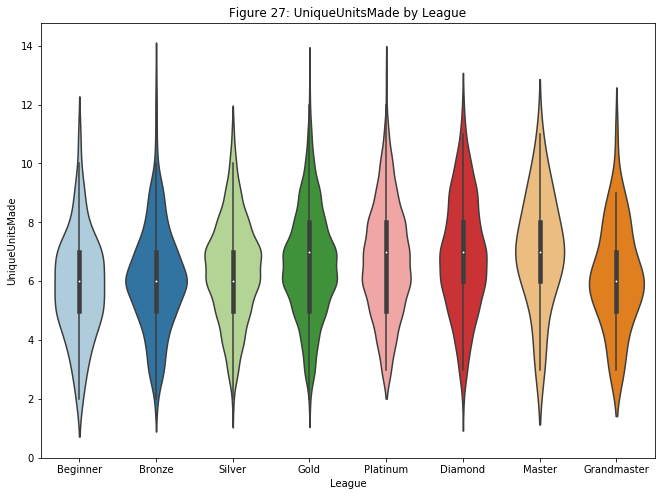

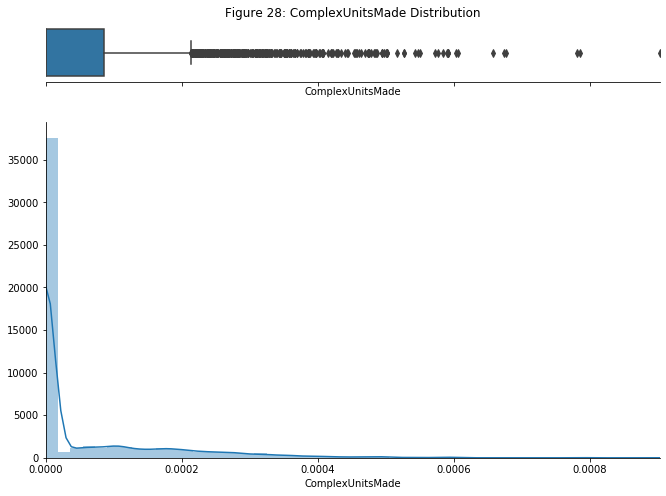

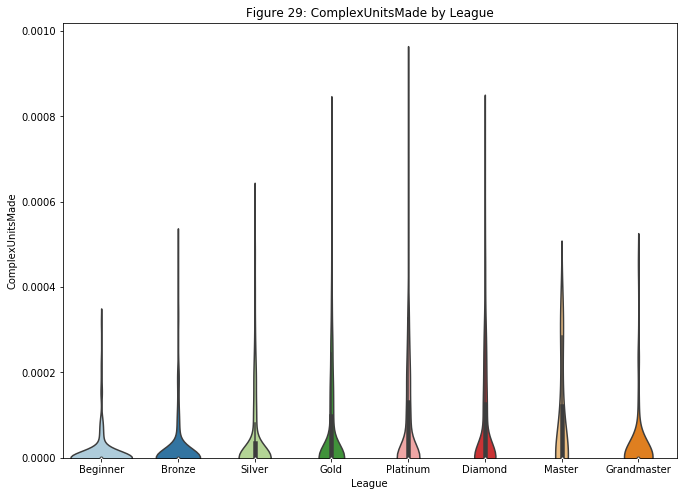

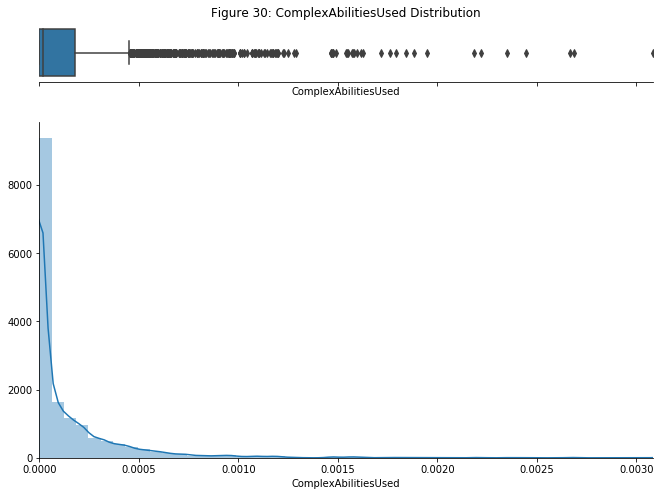

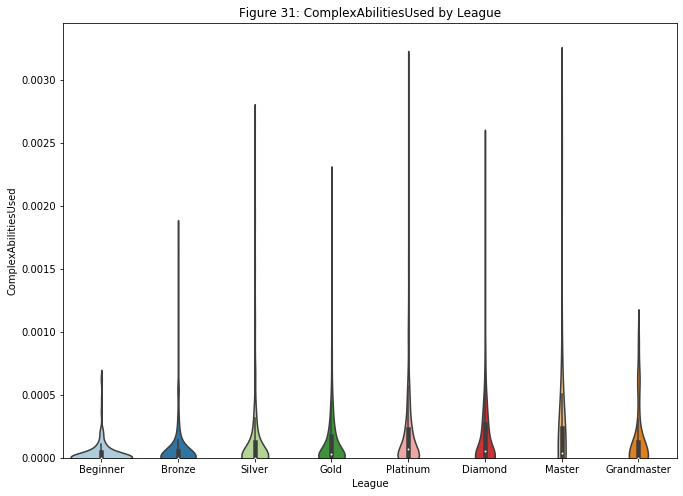

In [22]:
auto_plot("UniqueUnitsMade",26)
auto_plot("ComplexUnitsMade",28)
auto_plot("ComplexAbilitiesUsed",30)

Similar to WorkersMade, it will be very hard to differentiate players by using these features.

Depending on the strategy, a player can just win by making as little as 1 unit type, often having a very lean, specialized army can make greater impact than a large one with a lot of different units. Complex units as well as their abilities are accessible to any player with enough time and resources, but could still be used to differentiate weak players from average or better players.

# Data prep

Let's reencode the target variable into 5 artificial laegues

In [23]:
leagues = sc.LeagueIndex
sc_data = sc.drop(columns='LeagueIndex')
leagues.value_counts()

4    811
5    806
6    621
3    553
2    347
1    167
8     55
7     35
Name: LeagueIndex, dtype: int64

In [24]:
# Reencode
leagues.replace({2:1, 3:2, 4:3, 5:4, 6:5, 7:5, 8:5}, inplace=True)
# New Value Counts
leagues.value_counts()

3    811
4    806
5    711
2    553
1    514
Name: LeagueIndex, dtype: int64

Normalizing the data

In [111]:
def normalize_data(data):
    scaler = preprocessing.MinMaxScaler()
    data_norm = scaler.fit_transform(data)
    
    # When the data has been transformed, a np.array is returned,
    # So we have to convert it back to a dataframe, and insert column names
    return pd.DataFrame(data_norm, columns=data.columns)
    
sc_norm = normalize_data(sc_data)
sc_norm.describe()

GameID          APM  SelectByHotkeys  AssignToHotkeys  \
count  3395.000000  3395.000000      3395.000000      3395.000000   
mean      0.473266     0.258278         0.099764         0.213205   
std       0.270830     0.141243         0.122642         0.128373   
min       0.000000     0.000000         0.000000         0.000000   
25%       0.240217     0.157273         0.029192         0.116554   
50%       0.480135     0.233706         0.058009         0.201216   
75%       0.702629     0.328276         0.119117         0.284692   
max       1.000000     1.000000         1.000000         1.000000   

       UniqueHotkeys  MinimapAttacks  MinimapRightClicks  NumberOfPACs  \
count    3395.000000     3395.000000         3395.000000   3395.000000   
mean        0.436465        0.032559            0.095881      0.381792   
std         0.236033        0.054936            0.093298      0.136086   
min         0.000000        0.000000            0.000000      0.000000   
25%         0.300000        0.000000            0.034668      0.284532   
50%         0.400000        0.013225            0.069662      0.372539   
75%         0.600000        0.039364            0.127226      0.459170   
max         1.000000        1.000000            1.000000      1.000000   

       GapBetweenPACs  ActionLatency  ActionsInPAC  TotalMapExplored  \
count     3395.000000    3395.000000   3395.000000       3395.000000   
mean         0.146197       0.260351      0.195778          0.323239   
std          0.074427       0.126340      0.090491          0.140221   
min          0.000000       0.000000      0.000000          0.000000   
25%          0.096717       0.173058      0.135234          0.226415   
50%          0.130412       0.241913      0.185033          0.320755   
75%          0.180599       0.325638      0.241822          0.415094   
max          1.000000       1.000000      1.000000          1.000000   

       WorkersMade  UniqueUnitsMade  ComplexUnitsMade  ComplexAbilitiesUsed  
count  3395.000000      3395.000000       3395.000000           3395.000000  
mean      0.188218         0.412184          0.065870              0.046009  
std       0.102322         0.168882          0.123123              0.086016  
min       0.000000         0.000000          0.000000              0.000000  
25%       0.119468         0.272727          0.000000              0.000000  
50%       0.163290         0.363636          0.000000              0.006577  
75%       0.232964         0.545455          0.094805              0.058816  
max       1.000000         1.000000          1.000000              1.000000

Let's see if we can get something interesting using dim reduction and clustering (spoiler alert -nope)

In [122]:
sc_umap = sc.drop(['GameID'], axis = 1)

In [123]:
import umap.umap_ as umap

In [126]:
%%time
reducer_mnist = umap.UMAP(random_state=42, n_neighbors=10,
                      min_dist=0.3,
                      metric='correlation')
embedding = reducer_mnist.fit_transform(sc_umap)

CPU times: user 11.5 s, sys: 138 ms, total: 11.6 s
Wall time: 9.01 s


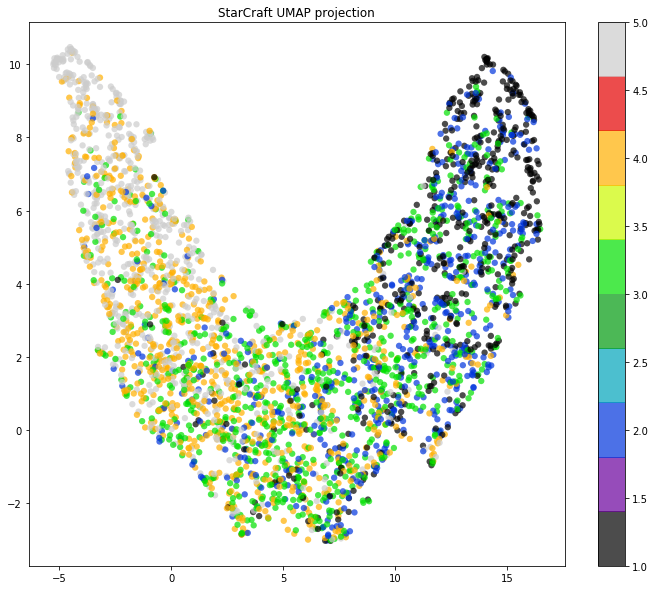

In [127]:
plt.figure(figsize=(12,10))
plt.scatter(embedding[:, 0], embedding[:, 1], c=sc['LeagueIndex'], 
            edgecolor='none', alpha=0.7, s=40,
            cmap=plt.cm.get_cmap('nipy_spectral', 10))
plt.colorbar()
plt.title('StarCraft UMAP projection');

In [ ]:
##TODO Clustering

In [133]:
from sklearn.cluster import DBSCAN

In [137]:
from sklearn.preprocessing import StandardScaler

In [425]:
def dbscan(X, eps, min_samples):
    ss = StandardScaler()
    X = ss.fit_transform(X)
    db = DBSCAN(eps=eps, min_samples=min_samples)
    db.fit(X)
    y_pred = db.fit_predict(X)
    plt.scatter(X[:,0], X[:,1],c=y_pred, cmap='Paired')
    plt.title("DBSCAN")

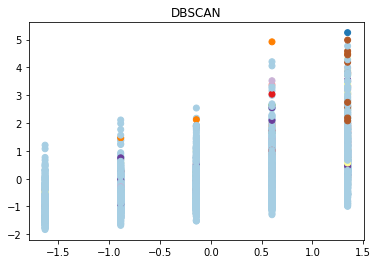

In [435]:
dbscan(sc_umap, 3, 0.1)

In [141]:
from sklearn.cluster import KMeans

In [142]:
def kmeans(X, n_clusters):
    ss = StandardScaler()
    X = ss.fit_transform(X)
    km = KMeans(n_clusters=n_clusters)
    km.fit(X)
    y_pred = km.predict(X)
    plt.scatter(X[:,0], X[:,1],c=y_pred, cmap='Paired')
    plt.title("K-means")

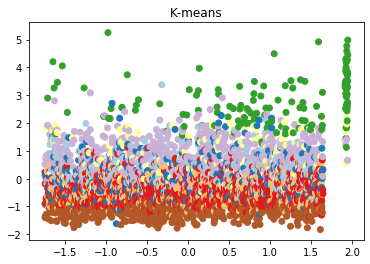

In [144]:
kmeans(sc_norm, 8)

Here we will use ANOVA F-value, Mutual Information and Chi-squared scoring on the full dataset to rank and select features.

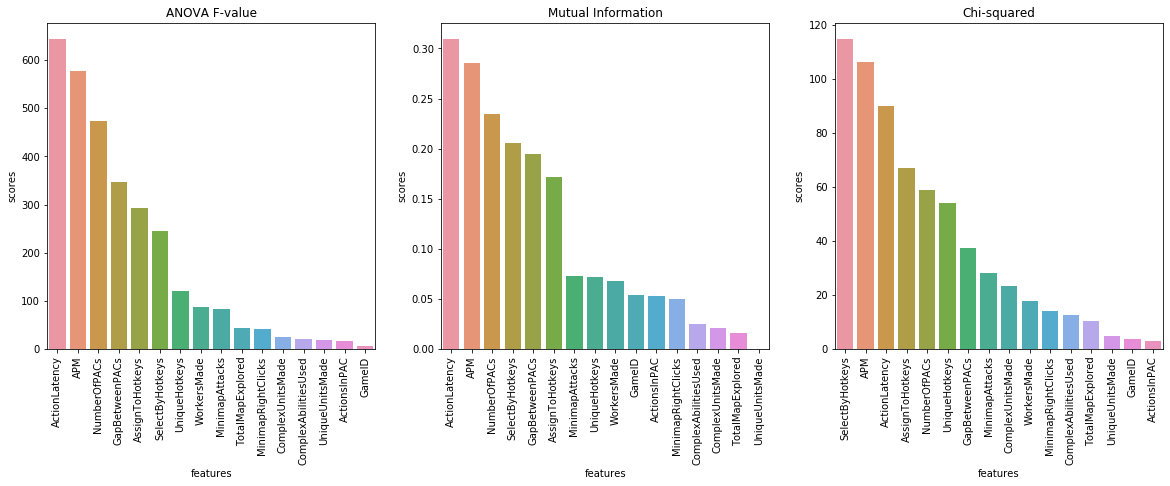

In [26]:
def plot_scores():
    def get_k_best(data, target, method, k):
        skb = SelectKBest(method, k = k)
        skb.fit(data.values, target.values)
        fs_indices = np.argsort(skb.scores_)[::-1]

        return pd.DataFrame({"features": data.columns[fs_indices].values, 
                      "scores": skb.scores_[fs_indices]})
    
    fig, axs = plt.subplots(ncols=3, figsize=(20,6))
    plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=0.6)
    
    titles = []
    data = []
    titles.append("ANOVA F-value")
    data.append(get_k_best(sc_norm, leagues, f_classif, len(sc_norm.columns)))
    titles.append("Mutual Information")
    data.append(get_k_best(sc_norm, leagues, mutual_info_classif, len(sc_norm.columns)))
    titles.append("Chi-squared")
    data.append(get_k_best(sc_norm, leagues, chi2, len(sc_norm.columns)))
    
    for i in range(3):
        p = sns.barplot(x='features', y='scores', data=data[i], ax=axs[i])
        p.set_xticklabels(p.get_xticklabels(), rotation=90)
        p.set_title(titles[i])
        

plot_scores()

## "Light" models approach

--1) KNN 
--2) DT
--3) NB
--4) SVC
--5) RFC
--6) LR

In [27]:
sc_train, sc_test, leagues_train, leagues_test = train_test_split(sc_norm, leagues, 
                                                                  test_size = 0.3, random_state=1,
                                                                  stratify = leagues)

print(f"Training dataset shape: {sc_train.shape}")
print(f"Test dataset shape: {sc_test.shape}")
print(f"Training target shape: {leagues_train.shape}")
print(f"Test target shape: {leagues_test.shape}")

Training dataset shape: (2376, 16)
Test dataset shape: (1019, 16)
Training target shape: (2376,)
Test target shape: (1019,)


In [28]:
from sklearn.model_selection import RepeatedStratifiedKFold, GridSearchCV

cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=1)

In [29]:
def run_KNN_pipe(n_neighbours, p):
    pipe_KNN = Pipeline([('selector', SelectKBest()), 
                         ('knn', KNeighborsClassifier())])

    params_pipe_KNN = {'selector__score_func': [f_classif, mutual_info_classif, chi2],
                       'selector__k': [3, 4, 5, 6, 7, 10, sc_norm.shape[1]],
                       'knn__n_neighbors': n_neighbours,
                       'knn__p': p}

    gs_pipe_KNN = GridSearchCV(estimator=pipe_KNN, 
                               param_grid=params_pipe_KNN, 
                               cv=cv,
                               n_jobs = -1,
                               scoring='accuracy',
                               verbose=0)

    gs_pipe_KNN.fit(sc_train, leagues_train);
    
    return gs_pipe_KNN


gs_pipe_KNN = run_KNN_pipe([150, 160 ,170 ,180 ,190, 200], [1,2,5])

In [30]:
gs_pipe_KNN.best_params_

{'knn__n_neighbors': 170,
 'knn__p': 1,
 'selector__k': 7,
 'selector__score_func': <function sklearn.feature_selection._mutual_info.mutual_info_classif(X, y, discrete_features='auto', n_neighbors=3, copy=True, random_state=None)>}

In [31]:
# custom function to format the search results as a Pandas data frame
def get_search_results(gs):

    def model_result(scores, params):
        scores = {'mean_score': np.mean(scores),
             'std_score': np.std(scores),
             'min_score': np.min(scores),
             'max_score': np.max(scores)}
        return pd.Series({**params,**scores})

    models = []
    scores = []

    for i in range(gs.n_splits_):
        key = f"split{i}_test_score"
        r = gs.cv_results_[key]        
        scores.append(r.reshape(-1,1))

    all_scores = np.hstack(scores)
    for p, s in zip(gs.cv_results_['params'], all_scores):
        models.append((model_result(s, p)))

    pipe_results = pd.concat(models, axis=1).T.sort_values(['mean_score'], ascending=False)

    columns_first = ['mean_score', 'std_score', 'max_score', 'min_score']
    columns = columns_first + [c for c in pipe_results.columns if c not in columns_first]

    return pipe_results[columns]

results_KNN = get_search_results(gs_pipe_KNN)
results_KNN.head(5)

mean_score  std_score max_score min_score knn__n_neighbors knn__p  \
139   0.445284  0.0164905  0.475789  0.410526              170      1   
17    0.444167  0.0186247  0.484211  0.412632              150      1   
156   0.443886  0.0169214  0.473684  0.418067              170      2   
157   0.443886  0.0169214  0.473684  0.418067              170      2   
93    0.443466  0.0176101  0.482105  0.418947              160      2   

    selector__k                            selector__score_func  
139           7  <function mutual_info_classif at 0x1a224d9a70>  
17           10                 <function chi2 at 0x1a21f25a70>  
156           6            <function f_classif at 0x1a21f25ef0>  
157           6  <function mutual_info_classif at 0x1a224d9a70>  
93            6            <function f_classif at 0x1a21f25ef0>

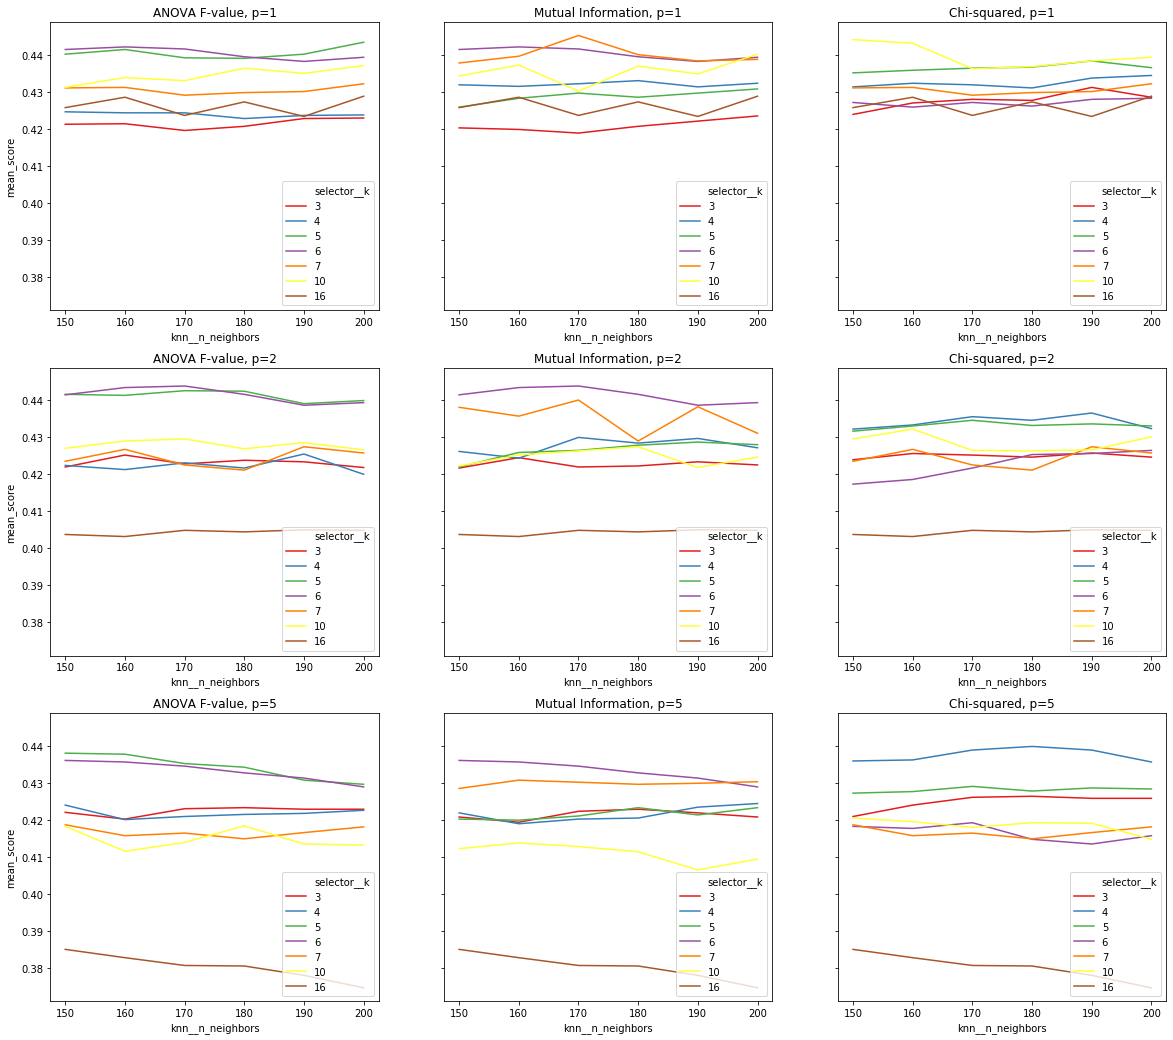

In [32]:
def plot_KNN_results(res):
    def get_selector_data(d, p, sel):
        return d[(d.knn__p==p) & (d.selector__score_func==sel)].iloc[:,[0,4,6]]
    
    rows = len(res["knn__p"].unique())
    
    fig, axs = plt.subplots(ncols=3, nrows=rows, figsize=(20,rows*6), sharey='all')
    plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=None)
    
    titles = []
    data = []
    temp = res.copy().infer_objects()
    for i, p in enumerate(res["knn__p"].unique()):
        titles.append(f"ANOVA F-value, p={p}")
        data.append(get_selector_data(temp, p, f_classif))
        titles.append(f"Mutual Information, p={p}")
        data.append(get_selector_data(temp, p, mutual_info_classif))
        titles.append(f"Chi-squared, p={p}")
        data.append(get_selector_data(temp, p, chi2))
    
    row = 0
    col = 0
    ax = None
    for i in range(rows*3):
        if col%3==0 and col!=0:
            col=0
            row+=1
        if rows == 1:
            ax = axs[col]
        else:
            ax=axs[row,col]
        p = sns.lineplot(x='knn__n_neighbors', 
                         y='mean_score', 
                         hue='selector__k', 
                         data=data[i], 
                         ax=ax, 
                         palette=sns.color_palette("Set1", 7))
        p.set_title(titles[i])
        p.legend(loc='lower right')
        col+=1
        
plot_KNN_results(results_KNN)

In [33]:
gs_pipe_KNN2 = run_KNN_pipe([210, 220, 230, 240, 250, 260, 270, 280, 290, 300, 310, 320, 330, 340, 350], [1])

In [34]:
gs_pipe_KNN2.best_score_

0.4448704113224237

In [35]:
results_KNN2 = get_search_results(gs_pipe_KNN2)
results_KNN2.head(5)

mean_score  std_score max_score min_score knn__n_neighbors knn__p  \
185    0.44487  0.0189237  0.473684  0.418947              290      1   
122    0.44487   0.017475  0.471579  0.414737              260      1   
80    0.444588  0.0184958  0.477895  0.423158              240      1   
135   0.444587   0.012865  0.469474  0.421053              270      1   
136   0.444587   0.012865  0.469474  0.421053              270      1   

    selector__k                            selector__score_func  
185          10                 <function chi2 at 0x1a21f25a70>  
122          10                 <function chi2 at 0x1a21f25a70>  
80           10                 <function chi2 at 0x1a21f25a70>  
135           6            <function f_classif at 0x1a21f25ef0>  
136           6  <function mutual_info_classif at 0x1a224d9a70>

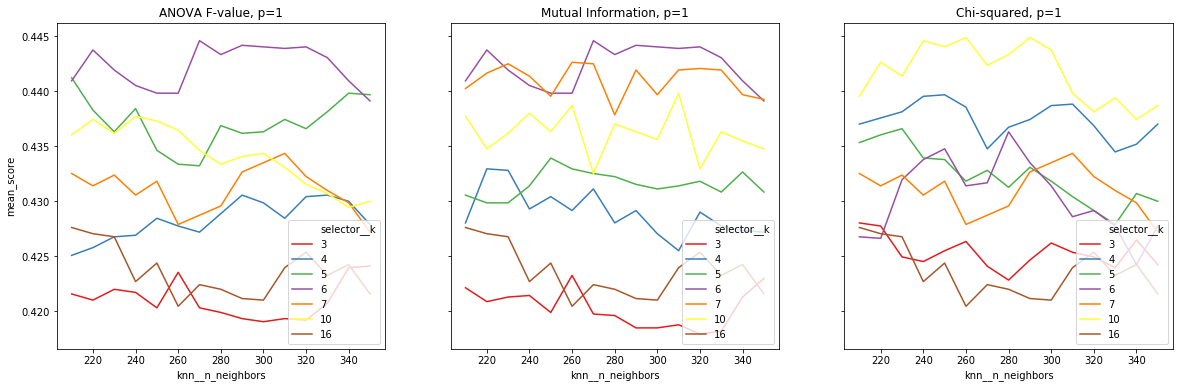

In [36]:
plot_KNN_results(results_KNN2)

In [37]:
def run_dt_pipe(max_depth, min_split):
    pipe_DT = Pipeline([('selector', SelectKBest()), 
                         ('dt', DecisionTreeClassifier(criterion='gini'))])

    params_pipe_DT = {'selector__score_func': [f_classif, mutual_info_classif, chi2],
                       'selector__k': [3, 4, 5, 6, 7, 10, sc_norm.shape[1]],
                       'dt__max_depth': max_depth,
                       'dt__min_samples_split': min_split}
 
    gs_pipe_DT = GridSearchCV(estimator=pipe_DT, 
                               param_grid=params_pipe_DT, 
                               cv=cv,
                               n_jobs = -1,
                               scoring='accuracy',
                               verbose=0)

    gs_pipe_DT.fit(sc_train, leagues_train);
    
    return gs_pipe_DT


gs_pipe_DT = run_dt_pipe([5, 7, 9], [2, 3, 5, 7, 9, 11])

In [38]:
gs_pipe_DT.best_params_

{'dt__max_depth': 5,
 'dt__min_samples_split': 5,
 'selector__k': 5,
 'selector__score_func': <function sklearn.feature_selection._mutual_info.mutual_info_classif(X, y, discrete_features='auto', n_neighbors=3, copy=True, random_state=None)>}

In [39]:
gs_pipe_DT.best_score_

0.4140091404983046

In [40]:
results_DT = get_search_results(gs_pipe_DT)
results_DT.head(5)

mean_score  std_score max_score min_score dt__max_depth  \
49    0.414009  0.0250487  0.475789  0.372632             5   
112   0.414009  0.0248831  0.475789  0.372632             5   
28    0.413869  0.0251137  0.475789  0.372632             5   
118   0.413163  0.0290626  0.465263  0.369748             5   
13    0.412601  0.0270794  0.460084  0.371849             5   

    dt__min_samples_split selector__k  \
49                      5           5   
112                    11           5   
28                      3           5   
118                    11           7   
13                      2           7   

                               selector__score_func  
49   <function mutual_info_classif at 0x1a224d9a70>  
112  <function mutual_info_classif at 0x1a224d9a70>  
28   <function mutual_info_classif at 0x1a224d9a70>  
118  <function mutual_info_classif at 0x1a224d9a70>  
13   <function mutual_info_classif at 0x1a224d9a70>

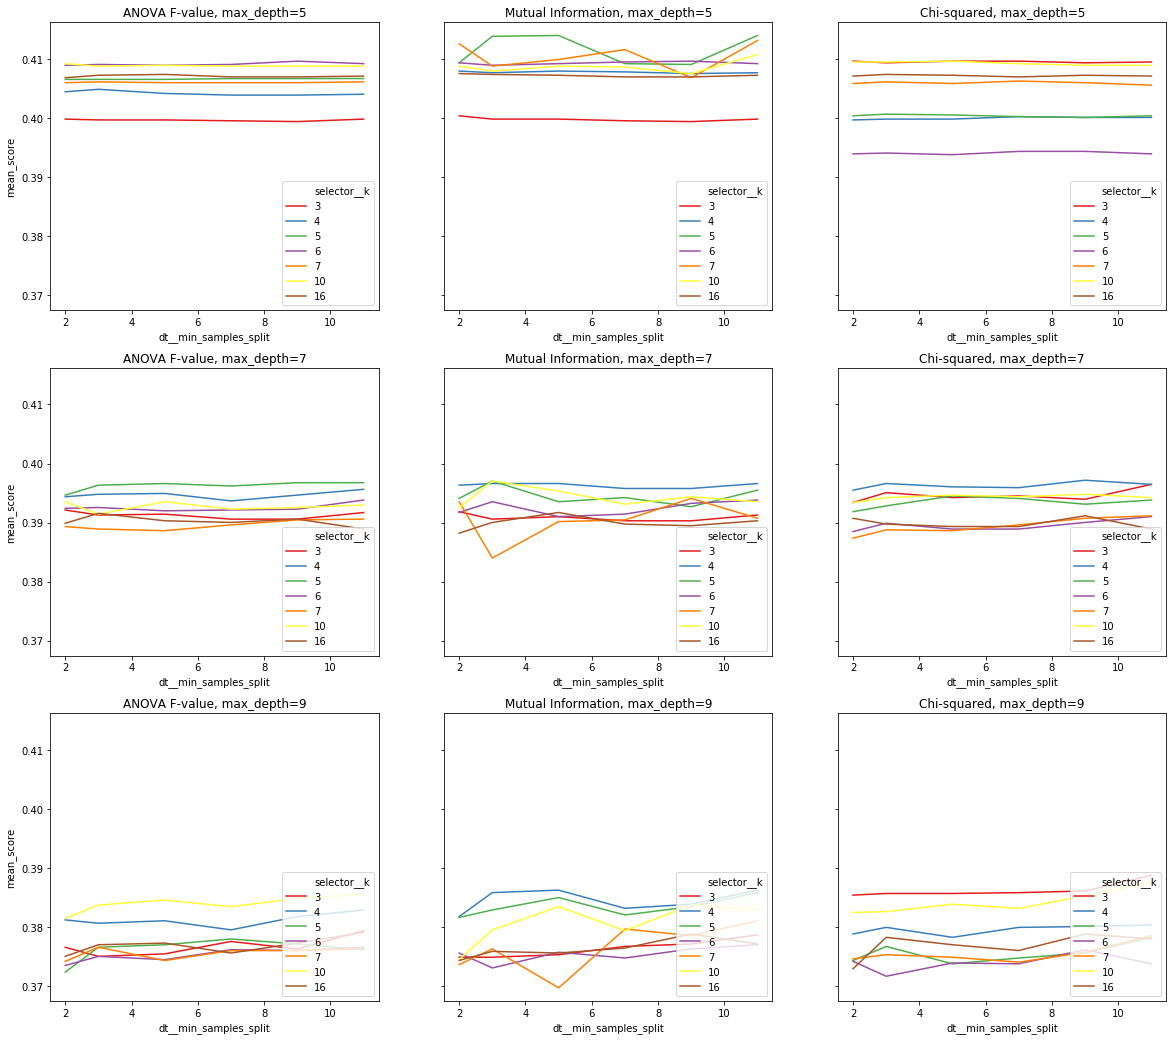

In [41]:
def plot_DT_results(res):
    def get_selector_data(d, p, sel):
        return d[(d.dt__max_depth==p) & (d.selector__score_func==sel)].iloc[:,[0,5,6]]
    
    rows = len(res["dt__max_depth"].unique())
    
    fig, axs = plt.subplots(ncols=3, nrows=rows, figsize=(20,rows*6), sharey='all')
    plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=None)
    
    titles = []
    data = []
    temp = res.copy().infer_objects()
    for i, p in enumerate(res["dt__max_depth"].unique()):
        titles.append(f"ANOVA F-value, max_depth={p}")
        data.append(get_selector_data(temp, p, f_classif))
        titles.append(f"Mutual Information, max_depth={p}")
        data.append(get_selector_data(temp, p, mutual_info_classif))
        titles.append(f"Chi-squared, max_depth={p}")
        data.append(get_selector_data(temp, p, chi2))
    
    row = 0
    col = 0
    ax = None
    for i in range(rows*3):
        if col%3==0 and col!=0:
            col=0
            row+=1
        if rows == 1:
            ax = axs[col]
        else:
            ax=axs[row,col]
        p = sns.lineplot(x='dt__min_samples_split', 
                         y='mean_score', 
                         hue='selector__k', 
                         data=data[i], 
                         ax=ax, 
                         palette=sns.color_palette("Set1", 7))
        p.set_title(titles[i])
        p.legend(loc='lower right')
        col+=1

        
plot_DT_results(results_DT)

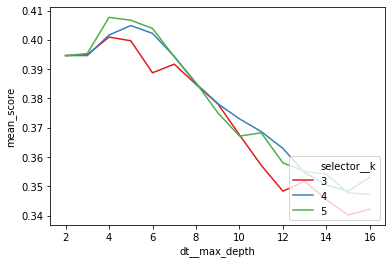

In [42]:
def compare_depths():
    def get_selector_data(d, p, sel):
        return d[(d.dt__min_samples_split==p) & (d.selector__score_func==sel)].iloc[:,[0,4,6]]
    
    pipe_DT = Pipeline([('selector', SelectKBest()), 
                         ('dt', DecisionTreeClassifier(criterion='gini'))])

    params_pipe_DT = {'selector__score_func': [f_classif],
                       'selector__k': [3, 4, 5],
                       'dt__max_depth': [2,3,4,5,6,7,8,9,10,11,12,13,14,15,16],
                       'dt__min_samples_split': [2]}
 
    gs_pipe_DT = GridSearchCV(estimator=pipe_DT, 
                               param_grid=params_pipe_DT, 
                               cv=cv,
                               n_jobs = -1,
                               scoring='accuracy',
                               verbose=0)

    res = get_search_results(gs_pipe_DT.fit(sc_train, leagues_train));
    res = res.infer_objects()
    p = sns.lineplot(x='dt__max_depth', 
                     y='mean_score', 
                     hue='selector__k', 
                     data=get_selector_data(res,2,f_classif), 
                     palette=sns.color_palette("Set1", 3))
    #p.set_title(titles[i])
    p.legend(loc='lower right')
    
compare_depths()

In [43]:
gs_pipe_DT2 = run_dt_pipe([5], [11, 21, 31, 41, 51, 61, 71, 81, 91, 101, 111, 121, 131, 141, 151, 161, 171, 181, 191, 201])

In [44]:
gs_pipe_DT2.best_params_

{'dt__max_depth': 5,
 'dt__min_samples_split': 161,
 'selector__k': 7,
 'selector__score_func': <function sklearn.feature_selection._mutual_info.mutual_info_classif(X, y, discrete_features='auto', n_neighbors=3, copy=True, random_state=None)>}

In [45]:
gs_pipe_DT2.best_score_

0.42101489016659294

In [46]:
results_DT2 = get_search_results(gs_pipe_DT2)
results_DT2.head(5)

mean_score  std_score max_score min_score dt__max_depth  \
328   0.421015  0.0251935   0.47479  0.383158             5   
238   0.420602  0.0249791  0.475789  0.381053             5   
322    0.42018   0.025531  0.475789  0.372632             5   
217    0.42004  0.0243637  0.473684  0.381053             5   
343   0.419479  0.0238011  0.463158  0.372632             5   

    dt__min_samples_split selector__k  \
328                   161           7   
238                   121           5   
322                   161           5   
217                   111           5   
343                   171           5   

                               selector__score_func  
328  <function mutual_info_classif at 0x1a224d9a70>  
238  <function mutual_info_classif at 0x1a224d9a70>  
322  <function mutual_info_classif at 0x1a224d9a70>  
217  <function mutual_info_classif at 0x1a224d9a70>  
343  <function mutual_info_classif at 0x1a224d9a70>

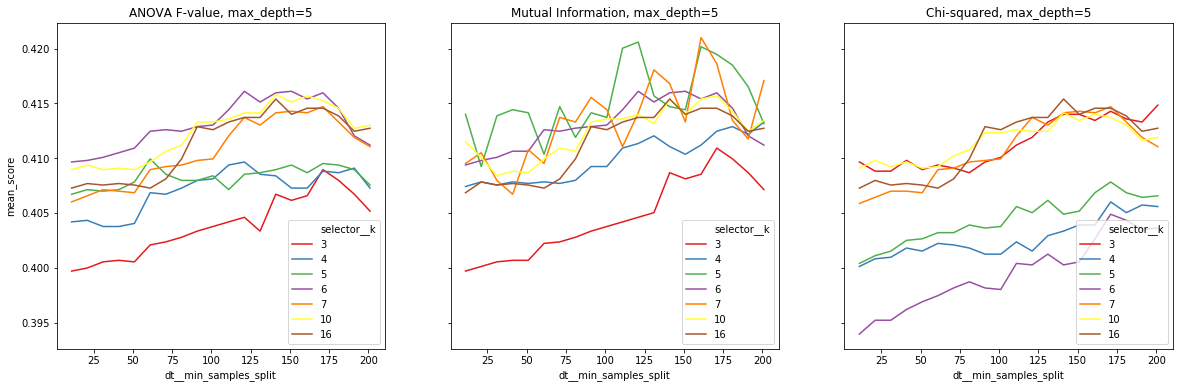

In [47]:
plot_DT_results(results_DT2)

In [48]:
np.random.seed(1)

def run_NB_pipe(var_smoothing):
    pipe_NB = Pipeline([('selector', SelectKBest()), 
                         ('nb', GaussianNB())])

    params_pipe_NB = {'selector__score_func': [f_classif, mutual_info_classif],
                       'selector__k': [3, 4, 5, 6, 7, 10, sc_norm.shape[1]],
                       'nb__var_smoothing': var_smoothing}

    gs_pipe_NB = GridSearchCV(estimator=pipe_NB, 
                               param_grid=params_pipe_NB, 
                               cv=cv,
                               n_jobs = -1,
                               scoring='accuracy',
                               verbose=0)
    
    sc_train_transformed = PowerTransformer().fit_transform(sc_train)
    gs_pipe_NB.fit(sc_train_transformed, leagues_train);
    
    return gs_pipe_NB


gs_pipe_NB = run_NB_pipe(np.logspace(2,-2, num=100))

In [49]:
gs_pipe_NB.best_params_

{'nb__var_smoothing': 0.17886495290574334,
 'selector__k': 10,
 'selector__score_func': <function sklearn.feature_selection._mutual_info.mutual_info_classif(X, y, discrete_features='auto', n_neighbors=3, copy=True, random_state=None)>}

In [50]:
gs_pipe_NB.best_score_

0.4657688338493292

In [51]:
results_NB = get_search_results(gs_pipe_NB)
results_NB.head(5)

mean_score  std_score max_score min_score nb__var_smoothing selector__k  \
963    0.465769  0.0203269  0.526316      0.44          0.178865          10   
921    0.465347  0.0152145  0.498947  0.444211          0.236449          10   
864    0.464085   0.014379  0.503158  0.437895          0.343047          10   
949    0.463944  0.0173558  0.501053  0.437895          0.196304          10   
1187   0.463663  0.0175326  0.505263  0.442105         0.0403702          10   

                                selector__score_func  
963   <function mutual_info_classif at 0x1a224d9a70>  
921   <function mutual_info_classif at 0x1a224d9a70>  
864             <function f_classif at 0x1a21f25ef0>  
949   <function mutual_info_classif at 0x1a224d9a70>  
1187  <function mutual_info_classif at 0x1a224d9a70>

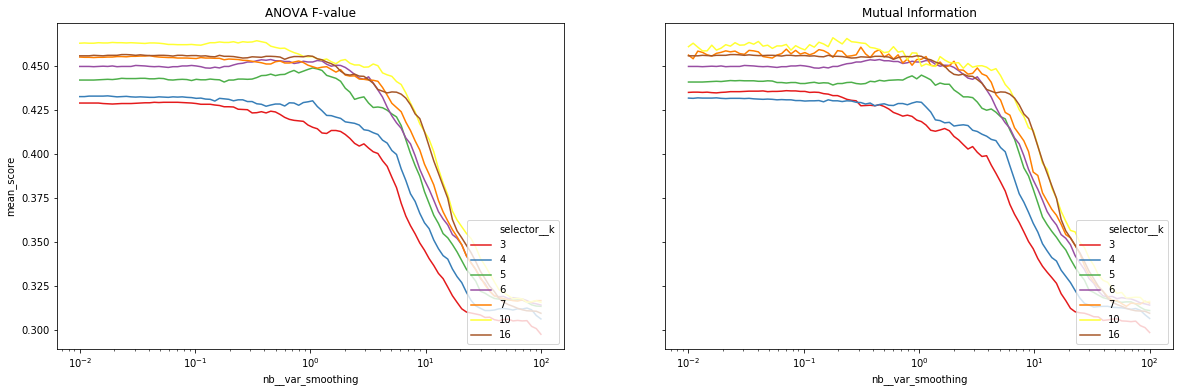

In [52]:
def plot_NB_results(res):
    def get_selector_data(d, sel):
        return d[(d.selector__score_func==sel)].iloc[:,[0,4,5]]
    
    fig, axs = plt.subplots(ncols=2, figsize=(20,6), sharey='all')
    plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=None)
    
    
    titles = []
    data = []
    temp = res.copy().infer_objects()
    
    titles.append(f"ANOVA F-value")
    data.append(get_selector_data(temp, f_classif))
    titles.append(f"Mutual Information")
    data.append(get_selector_data(temp, mutual_info_classif))
    
    for i in range(2):
        p = sns.lineplot(x='nb__var_smoothing', 
                         y='mean_score', 
                         hue='selector__k', 
                         data=data[i], 
                         ax=axs[i], 
                         palette=sns.color_palette("Set1", 7))
        p.set_xscale("log")
        p.set_title(titles[i])
        p.legend(loc='lower right')


plot_NB_results(results_NB)

In [53]:
cv2 = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=2)

cv_results_KNN = cross_val_score(estimator=gs_pipe_KNN2.best_estimator_,
                                 X=sc_test,
                                 y=leagues_test, 
                                 cv=cv2, 
                                 n_jobs=-1,
                                 scoring='accuracy')
cv_results_KNN.mean()

0.44289458357600464

In [54]:
cv_results_DT = cross_val_score(estimator=gs_pipe_DT2.best_estimator_,
                                X=sc_test,
                                y=leagues_test, 
                                cv=cv2, 
                                n_jobs=-1,
                                scoring='accuracy')
cv_results_DT.mean()

0.40889147738303244

In [55]:
sc_test_transformed = PowerTransformer().fit_transform(sc_test)

cv_results_NB = cross_val_score(estimator=gs_pipe_NB.best_estimator_,
                                X=sc_test_transformed,
                                y=leagues_test, 
                                cv=cv2, 
                                n_jobs=-1,
                                scoring='accuracy')
cv_results_NB.mean()

0.45631592571021806

In [56]:
print(stats.ttest_rel(cv_results_KNN, cv_results_DT))
print(stats.ttest_rel(cv_results_KNN, cv_results_NB))
print(stats.ttest_rel(cv_results_DT, cv_results_NB))

Ttest_relResult(statistic=3.573927305116578, pvalue=0.0012544979177349085)
Ttest_relResult(statistic=-2.0926845274415364, pvalue=0.04523899918618271)
Ttest_relResult(statistic=-6.146739288411167, pvalue=1.065766083680685e-06)


In [57]:
pred_KNN = gs_pipe_KNN.predict(sc_test)

pred_DT = gs_pipe_DT2.predict(sc_test)

sc_test_transformed = PowerTransformer().fit_transform(sc_test)
pred_NB = gs_pipe_NB.predict(sc_test_transformed)

print("\nK-Nearest Neighbour Report") 
print(metrics.classification_report(leagues_test, pred_KNN))
print("\nDecision Tree Report") 
print(metrics.classification_report(leagues_test, pred_DT))
print("\nNaive Bayes Report") 
print(metrics.classification_report(leagues_test, pred_NB))


K-Nearest Neighbour Report
              precision    recall  f1-score   support

           1       0.52      0.57      0.54       154
           2       0.23      0.11      0.15       166
           3       0.34      0.55      0.42       244
           4       0.43      0.32      0.37       242
           5       0.68      0.60      0.64       213

    accuracy                           0.44      1019
   macro avg       0.44      0.43      0.42      1019
weighted avg       0.44      0.44      0.43      1019


Decision Tree Report
              precision    recall  f1-score   support

           1       0.46      0.55      0.50       154
           2       0.32      0.24      0.28       166
           3       0.31      0.48      0.38       244
           4       0.35      0.31      0.33       242
           5       0.68      0.40      0.51       213

    accuracy                           0.39      1019
   macro avg       0.43      0.40      0.40      1019
weighted avg       0.42    

In [58]:
print("\nConfusion matrix for K-Nearest Neighbour") 
print(metrics.confusion_matrix(leagues_test, pred_KNN))
print("\nConfusion matrix for Decision Tree") 
print(metrics.confusion_matrix(leagues_test, pred_DT))
print("\nConfusion matrix for Naive Bayes") 
print(metrics.confusion_matrix(leagues_test, pred_NB))


Confusion matrix for K-Nearest Neighbour
[[ 88  28  34   3   1]
 [ 52  19  79  14   2]
 [ 28  28 135  34  19]
 [  2   7 118  77  38]
 [  0   2  33  50 128]]

Confusion matrix for Decision Tree
[[ 84  37  32   1   0]
 [ 48  40  62  14   2]
 [ 40  36 117  40  11]
 [ 10   8 121  75  28]
 [  0   3  40  84  86]]

Confusion matrix for Naive Bayes
[[ 99  36  14   4   1]
 [ 62  27  50  23   4]
 [ 39  38  93  49  25]
 [  2  16  70  93  61]
 [  0   0  22  48 143]]


From the reports and confusion matrix, NB and KNN are very closely matched for the highest averages for precision, recall and accuracy. However, upon closer inspection NB and KNN has a very wide range in all its scores such as going from a recall of 0.61 in class 1 to 0.14 in class 2, whereas DT is the most balanced. The confusion matrix does align with these findings.

Let's move on

In [63]:
from sklearn.svm import SVC

In [73]:
def run_svc_pipe(C):
    pipe_svc = Pipeline([('selector', SelectKBest()), 
                         ('svc', SVC(class_weight='balanced', decision_function_shape = "ovo"))])

    params_pipe_svc = {'selector__score_func': [f_classif, mutual_info_classif, chi2],
                       'selector__k': [3, 4, 5, 6, 7, 10, sc_norm.shape[1]],
                       'svc__C': C}
 
    gs_pipe_svc = GridSearchCV(estimator=pipe_svc, 
                               param_grid=params_pipe_svc, 
                               cv=cv,
                               n_jobs = -1,
                               scoring='accuracy',
                               verbose=0)

    gs_pipe_svc.fit(sc_train, leagues_train);
    
    return gs_pipe_svc


gs_pipe_svc = run_svc_pipe([0.001, 0.01, 1, 10])

In [74]:
gs_pipe_svc.best_params_

{'selector__k': 5,
 'selector__score_func': <function sklearn.feature_selection._univariate_selection.f_classif(X, y)>,
 'svc__C': 1}

In [75]:
gs_pipe_svc.best_score_

0.4507580716497125

In [76]:
results_svc = get_search_results(gs_pipe_svc)
results_svc.head(5)

mean_score  std_score max_score min_score selector__k  \
26   0.450758  0.0148129  0.475789  0.427368           5   
42    0.44767  0.0134197  0.471579  0.416842           6   
38    0.44767  0.0134197  0.471579  0.416842           6   
54   0.447532  0.0174651      0.48  0.402105           7   
62   0.446974  0.0184655      0.48  0.416842          10   

                              selector__score_func svc__C  
26            <function f_classif at 0x1a21f25ef0>      1  
42  <function mutual_info_classif at 0x1a224d9a70>      1  
38            <function f_classif at 0x1a21f25ef0>      1  
54  <function mutual_info_classif at 0x1a224d9a70>      1  
62            <function f_classif at 0x1a21f25ef0>      1

In [78]:
def run_svc_pipe_2(C):
    pipe_svc = Pipeline([('selector', SelectKBest()), 
                         ('svc', SVC(class_weight='balanced', decision_function_shape = "ovr"))])

    params_pipe_svc2 = {'selector__score_func': [f_classif, mutual_info_classif, chi2],
                       'selector__k': [3, 4, 5, 6, 7, 10, sc_norm.shape[1]],
                       'svc__C': C}
 
    gs_pipe_svc2 = GridSearchCV(estimator=pipe_svc, 
                               param_grid=params_pipe_svc2, 
                               cv=cv,
                               n_jobs = -1,
                               scoring='accuracy',
                               verbose=0)

    gs_pipe_svc2.fit(sc_train, leagues_train);
    
    return gs_pipe_svc2


gs_pipe_svc2 = run_svc_pipe_2([0.001, 0.01, 1, 10])

In [79]:
gs_pipe_svc2.best_params_

{'selector__k': 5,
 'selector__score_func': <function sklearn.feature_selection._univariate_selection.f_classif(X, y)>,
 'svc__C': 1}

In [80]:
gs_pipe_svc2.best_score_

0.4507580716497125

In [81]:
results_svc2 = get_search_results(gs_pipe_svc2)
results_svc2.head(5)

mean_score  std_score max_score min_score selector__k  \
26   0.450758  0.0148129  0.475789  0.427368           5   
54   0.449075   0.021633  0.488421  0.402105           7   
42    0.44767  0.0134197  0.471579  0.416842           6   
38    0.44767  0.0134197  0.471579  0.416842           6   
62   0.446974  0.0184655      0.48  0.416842          10   

                              selector__score_func svc__C  
26            <function f_classif at 0x1a21f25ef0>      1  
54  <function mutual_info_classif at 0x1a224d9a70>      1  
42  <function mutual_info_classif at 0x1a224d9a70>      1  
38            <function f_classif at 0x1a21f25ef0>      1  
62            <function f_classif at 0x1a21f25ef0>      1

In [83]:
from sklearn.linear_model import LogisticRegression

In [88]:
def run_lr_pipe(C):
    pipe_lr = Pipeline([('selector', SelectKBest()), 
                         ('lr', LogisticRegression(class_weight = 'balanced', multi_class = 'multinomial', solver = 'newton-cg'))])

    params_pipe_lr = {'selector__score_func': [f_classif, mutual_info_classif, chi2],
                       'selector__k': [3, 4, 5, 6, 7, 10, sc_norm.shape[1]],
                       'lr__C': C}
 
    gs_pipe_lr = GridSearchCV(estimator=pipe_lr, 
                               param_grid=params_pipe_lr, 
                               cv=cv,
                               n_jobs = -1,
                               scoring='accuracy',
                               verbose=0)

    gs_pipe_lr.fit(sc_train, leagues_train);
    
    return gs_pipe_lr


gs_pipe_lr = run_lr_pipe([0.001, 0.01, 1, 10])

In [89]:
gs_pipe_lr.best_params_

{'selector__k': 10,
 'selector__score_func': <function sklearn.feature_selection._univariate_selection.f_classif(X, y)>,
 'svc__C': 10}

In [90]:
gs_pipe_lr.best_score_

0.45833583959899754

In [91]:
results_lr = get_search_results(gs_pipe_lr)
results_lr.head(5)

mean_score  std_score max_score min_score selector__k  \
63   0.458336  0.0136712  0.482105  0.434874          10   
67   0.456231  0.0131707  0.477895  0.433684          10   
71   0.452863  0.0162366  0.489496  0.430672          10   
51   0.451462  0.0172241  0.490526  0.420168           7   
59   0.451462  0.0172241  0.490526  0.420168           7   

                              selector__score_func svc__C  
63            <function f_classif at 0x1a21f25ef0>     10  
67  <function mutual_info_classif at 0x1a224d9a70>     10  
71                 <function chi2 at 0x1a21f25a70>     10  
51            <function f_classif at 0x1a21f25ef0>     10  
59                 <function chi2 at 0x1a21f25a70>     10

In [93]:
from sklearn.ensemble import RandomForestClassifier

In [102]:
def run_rfc_pipe(n_estimators, criterion, max_depth):
    pipe_rfc = Pipeline([('selector', SelectKBest()), 
                         ('rfc', RandomForestClassifier(class_weight = 'balanced', oob_score = True))])

    params_pipe_rfc = {'selector__score_func': [f_classif, mutual_info_classif, chi2],
                       'selector__k': [3, 4, 5, 6, 7, 10, sc_norm.shape[1]]}
 
    gs_pipe_rfc = GridSearchCV(estimator=pipe_rfc, 
                               param_grid=params_pipe_rfc, 
                               cv=cv,
                               n_jobs = -1,
                               scoring='accuracy',
                               verbose=0)

    gs_pipe_rfc.fit(sc_train, leagues_train);
    
    return gs_pipe_rfc


gs_pipe_rfc = run_rfc_pipe(n_estimators = [10, 100, 1000], criterion = ["gini", 'entropy'], max_depth = [5, 7, 9, 11, 13, 15] )

In [103]:
gs_pipe_rfc.best_params_

{'selector__k': 16,
 'selector__score_func': <function sklearn.feature_selection._univariate_selection.chi2(X, y)>}

In [104]:
gs_pipe_rfc.best_score_

0.43939761167624947

In [105]:
results_rfc = get_search_results(gs_pipe_rfc)
results_rfc.head(5)

mean_score  std_score max_score min_score selector__k  \
20   0.439398  0.0166338  0.475789  0.414737          16   
18   0.437995  0.0187842  0.490526  0.407563          16   
19   0.434064  0.0173751  0.463158  0.407563          16   
17   0.431686  0.0179207  0.461053  0.397059          10   
15    0.43112   0.019134  0.475789  0.402105          10   

                              selector__score_func  
20                 <function chi2 at 0x1a21f25a70>  
18            <function f_classif at 0x1a21f25ef0>  
19  <function mutual_info_classif at 0x1a224d9a70>  
17                 <function chi2 at 0x1a21f25a70>  
15            <function f_classif at 0x1a21f25ef0>

Of all the "light" models, judging by the results obtained, I would bet more on LogisticRegression

Let's try out boosting now

In [437]:
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier

In [151]:
leagues_train

2835    1
1292    4
2629    3
2620    5
2195    5
       ..
2868    4
83      1
1868    2
1701    2
2618    2
Name: LeagueIndex, Length: 2376, dtype: int64

In [169]:
# fit a CatBoost model to the data
params_cbc = {'depth':3,
         'loss_function': 'MultiClass',
          'iterations':1000,
          'learning_rate':0.001, 
          'l2_leaf_reg':1,
          'border_count':32}
cbc = CatBoostClassifier(**params_cbc )
cbc.fit(sc_train, leagues_train)
print(); print(cbc)

# make predictions
expected_y  = leagues_test
predicted_y = cbc.predict(sc_test)

# summarize the fit of the model
print(); print('CatBoost: ')
print(); print(metrics.classification_report(expected_y, predicted_y))
print(); print(metrics.confusion_matrix(expected_y, predicted_y))

0:	learn: 1.6089564	total: 2.8ms	remaining: 2.8s
1:	learn: 1.6085326	total: 5.86ms	remaining: 2.92s
2:	learn: 1.6080290	total: 8.09ms	remaining: 2.69s
3:	learn: 1.6075398	total: 10.8ms	remaining: 2.69s
4:	learn: 1.6071106	total: 13.1ms	remaining: 2.61s
5:	learn: 1.6066587	total: 15.7ms	remaining: 2.61s
6:	learn: 1.6062052	total: 18.1ms	remaining: 2.57s
7:	learn: 1.6057240	total: 20.4ms	remaining: 2.52s
8:	learn: 1.6052033	total: 22.5ms	remaining: 2.48s
9:	learn: 1.6047747	total: 25.2ms	remaining: 2.49s
10:	learn: 1.6043574	total: 27.2ms	remaining: 2.45s
11:	learn: 1.6038663	total: 30.1ms	remaining: 2.48s
12:	learn: 1.6033583	total: 31.8ms	remaining: 2.41s
13:	learn: 1.6028461	total: 34.2ms	remaining: 2.41s
14:	learn: 1.6023646	total: 37.5ms	remaining: 2.46s
15:	learn: 1.6018758	total: 40.6ms	remaining: 2.49s
16:	learn: 1.6013932	total: 43.6ms	remaining: 2.52s
17:	learn: 1.6009032	total: 46.7ms	remaining: 2.55s
18:	learn: 1.6004895	total: 50.3ms	remaining: 2.6s
19:	learn: 1.6000198	tota

In [164]:
# fit a LightGBM model to the data
lgbc = LGBMClassifier(objective = 'multiclass', boosting = 'dart', num_class = 5, class_weight = 'balanced')
lgbc.fit(sc_train, leagues_train)
print(); print(lgbc)

# make predictions
expected_y  = leagues_test
predicted_y = lgbc.predict(sc_test)
    
# summarize the fit of the model
print(); print('LightGBM: ')
print(); print(metrics.classification_report(expected_y, predicted_y))
print(); print(metrics.confusion_matrix(expected_y, predicted_y)) 


LGBMClassifier(boosting='dart', boosting_type='gbdt', class_weight='balanced',
               colsample_bytree=1.0, importance_type='split', learning_rate=0.1,
               max_depth=-1, min_child_samples=20, min_child_weight=0.001,
               min_split_gain=0.0, n_estimators=100, n_jobs=-1, num_class=5,
               num_leaves=31, objective='multiclass', random_state=None,
               reg_alpha=0.0, reg_lambda=0.0, silent=True, subsample=1.0,
               subsample_for_bin=200000, subsample_freq=0)

LightGBM: 

              precision    recall  f1-score   support

           1       0.51      0.64      0.57       154
           2       0.31      0.31      0.31       166
           3       0.31      0.28      0.29       244
           4       0.38      0.33      0.35       242
           5       0.60      0.64      0.62       213

    accuracy                           0.43      1019
   macro avg       0.42      0.44      0.43      1019
weighted avg       0.42      0.43 

Boosting algorithms do not show significant performance increase

# Neural Nets

Let's try Nueral Nets now. 
We will start with basic MLP implementation, followed by simple Keras NN and finally a complex pytorch built NN

Simple NN

In [171]:
from sklearn.neural_network import MLPClassifier

In [172]:
nn = MLPClassifier(hidden_layer_sizes=(100,100,100), max_iter=500, alpha=0.0001,
                     solver='sgd', verbose=10,  random_state=21,tol=0.000000001)

In [174]:
nn.fit(sc_train, leagues_train)
y_pred_nn = nn.predict(sc_test)

Iteration 1, loss = 1.61149912
Iteration 2, loss = 1.60670121
Iteration 3, loss = 1.60152016
Iteration 4, loss = 1.59655474
Iteration 5, loss = 1.59258057
Iteration 6, loss = 1.58884071
Iteration 7, loss = 1.58573606
Iteration 8, loss = 1.58294241
Iteration 9, loss = 1.58052890
Iteration 10, loss = 1.57841127
Iteration 11, loss = 1.57633063
Iteration 12, loss = 1.57440934
Iteration 13, loss = 1.57264889
Iteration 14, loss = 1.57110276
Iteration 15, loss = 1.56947786
Iteration 16, loss = 1.56801512
Iteration 17, loss = 1.56659489
Iteration 18, loss = 1.56518994
Iteration 19, loss = 1.56386412
Iteration 20, loss = 1.56254848
Iteration 21, loss = 1.56127892
Iteration 22, loss = 1.55987382
Iteration 23, loss = 1.55857241
Iteration 24, loss = 1.55720160
Iteration 25, loss = 1.55591104
Iteration 26, loss = 1.55446574
Iteration 27, loss = 1.55317204
Iteration 28, loss = 1.55168898
Iteration 29, loss = 1.55027893
Iteration 30, loss = 1.54883073
Iteration 31, loss = 1.54729289
Iteration 32, los

/Users/pavelgolubev/opt/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


In [177]:
from sklearn.metrics import accuracy_score

In [178]:
accuracy_score(leagues_test,y_pred_nn)

0.4533856722276742

Custom Keras model

In [254]:
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier
from keras.utils import np_utils
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline

Using TensorFlow backend.


In [301]:
X_ker = sc.copy().drop(['GameID', "LeagueIndex"], axis = 1)
y_ker = sc['LeagueIndex']

In [303]:
X_ker

APM  SelectByHotkeys  AssignToHotkeys  UniqueHotkeys  \
0     143.7180         0.003515         0.000220              7   
1     129.2322         0.003304         0.000259              4   
2      69.9612         0.001101         0.000336              4   
3     107.6016         0.001034         0.000213              1   
4     122.8908         0.001136         0.000327              2   
...        ...              ...              ...            ...   
3390  259.6296         0.020425         0.000743              9   
3391  314.6700         0.028043         0.001157             10   
3392  299.4282         0.028341         0.000860              7   
3393  375.8664         0.036436         0.000594              5   
3394  348.3576         0.029855         0.000811              4   

      MinimapAttacks  MinimapRightClicks  NumberOfPACs  GapBetweenPACs  \
0           0.000110            0.000392      0.004849         32.6677   
1           0.000294            0.000432      0.004307         32.9194   
2           0.000294            0.000461      0.002926         44.6475   
3           0.000053            0.000543      0.003783         29.2203   
4           0.000000            0.001329      0.002368         22.6885   
...              ...                 ...           ...             ...   
3390        0.000621            0.000146      0.004555         18.6059   
3391        0.000246            0.001083      0.004259         14.3023   
3392        0.000338            0.000169      0.004439         12.4028   
3393        0.000204            0.000780      0.004346         11.6910   
3394        0.000224            0.001315      0.005566         20.0537   

      ActionLatency  ActionsInPAC  TotalMapExplored  WorkersMade  \
0           40.8673        4.7508                28     0.001397   
1           42.3454        4.8434                22     0.001194   
2           75.3548        4.0430                22     0.000745   
3           53.7352        4.9155                19     0.000426   
4           62.0813        9.3740                15     0.001174   
...             ...           ...               ...          ...   
3390        42.8342        6.2754                46     0.000877   
3391        36.1156        7.1965                16     0.000788   
3392        39.5156        6.3979                19     0.001260   
3393        34.8547        7.9615                15     0.000613   
3394        33.5142        6.3719                27     0.001566   

      UniqueUnitsMade  ComplexUnitsMade  ComplexAbilitiesUsed  
0                   6          0.000000              0.000000  
1                   5          0.000000              0.000208  
2                   6          0.000000              0.000189  
3                   7          0.000000              0.000384  
4                   4          0.000000              0.000019  
...               ...               ...                   ...  
3390                5          0.000000              0.000000  
3391                4          0.000000              0.000000  
3392                4          0.000000              0.000000  
3393                6          0.000000              0.000631  
3394                7          0.000457              0.000895  

[3395 rows x 15 columns]

In [306]:
# encode class values as integers
encoder = LabelEncoder()
encoder.fit(y_ker)
encoded_Y = encoder.transform(y_ker)
# convert integers to dummy variables (i.e. one hot encoded)
dummy_y = np_utils.to_categorical(encoded_Y)
 
# define baseline model
def baseline_model():
	# create model
	model = Sequential()
	model.add(Dense(8, input_dim=15, activation='relu'))
	model.add(Dense(5, activation='softmax'))
	# Compile model
	model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
	return model
 
estimator = KerasClassifier(build_fn=baseline_model, epochs=200, batch_size=5, verbose=0)
kfold = KFold(n_splits=10, shuffle=True)
results = cross_val_score(estimator, X_ker, dummy_y, cv=kfold)
print("Baseline: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))

Baseline: 43.65% (2.34%)


Complex pytorch NN

In [307]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler

from sklearn.preprocessing import MinMaxScaler    

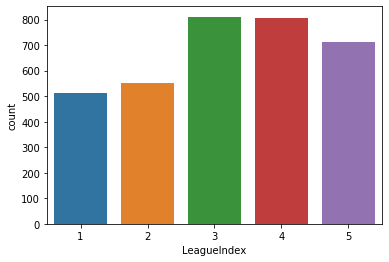

In [308]:
sns.countplot(x = 'LeagueIndex', data=sc)

In [309]:
class2idx = {
    1:0,
    2:1,
    3:2,
    4:3,
    5:4
}

idx2class = {v: k for k, v in class2idx.items()}

In [310]:
sc_torch = sc.copy()

In [311]:
sc_torch['LeagueIndex'].replace(class2idx, inplace=True)

In [314]:
np.unique(sc_torch['LeagueIndex'])

array([0, 1, 2, 3, 4])

In [318]:
X_torch = sc_torch.iloc[:, 2:]
y_torch = sc_torch.iloc[:, 1]

In [319]:
X_torch

APM  SelectByHotkeys  AssignToHotkeys  UniqueHotkeys  \
0     143.7180         0.003515         0.000220              7   
1     129.2322         0.003304         0.000259              4   
2      69.9612         0.001101         0.000336              4   
3     107.6016         0.001034         0.000213              1   
4     122.8908         0.001136         0.000327              2   
...        ...              ...              ...            ...   
3390  259.6296         0.020425         0.000743              9   
3391  314.6700         0.028043         0.001157             10   
3392  299.4282         0.028341         0.000860              7   
3393  375.8664         0.036436         0.000594              5   
3394  348.3576         0.029855         0.000811              4   

      MinimapAttacks  MinimapRightClicks  NumberOfPACs  GapBetweenPACs  \
0           0.000110            0.000392      0.004849         32.6677   
1           0.000294            0.000432      0.004307         32.9194   
2           0.000294            0.000461      0.002926         44.6475   
3           0.000053            0.000543      0.003783         29.2203   
4           0.000000            0.001329      0.002368         22.6885   
...              ...                 ...           ...             ...   
3390        0.000621            0.000146      0.004555         18.6059   
3391        0.000246            0.001083      0.004259         14.3023   
3392        0.000338            0.000169      0.004439         12.4028   
3393        0.000204            0.000780      0.004346         11.6910   
3394        0.000224            0.001315      0.005566         20.0537   

      ActionLatency  ActionsInPAC  TotalMapExplored  WorkersMade  \
0           40.8673        4.7508                28     0.001397   
1           42.3454        4.8434                22     0.001194   
2           75.3548        4.0430                22     0.000745   
3           53.7352        4.9155                19     0.000426   
4           62.0813        9.3740                15     0.001174   
...             ...           ...               ...          ...   
3390        42.8342        6.2754                46     0.000877   
3391        36.1156        7.1965                16     0.000788   
3392        39.5156        6.3979                19     0.001260   
3393        34.8547        7.9615                15     0.000613   
3394        33.5142        6.3719                27     0.001566   

      UniqueUnitsMade  ComplexUnitsMade  ComplexAbilitiesUsed  
0                   6          0.000000              0.000000  
1                   5          0.000000              0.000208  
2                   6          0.000000              0.000189  
3                   7          0.000000              0.000384  
4                   4          0.000000              0.000019  
...               ...               ...                   ...  
3390                5          0.000000              0.000000  
3391                4          0.000000              0.000000  
3392                4          0.000000              0.000000  
3393                6          0.000000              0.000631  
3394                7          0.000457              0.000895  

[3395 rows x 15 columns]

In [320]:
y_torch

0       3
1       3
2       2
3       1
4       1
       ..
3390    4
3391    4
3392    4
3393    4
3394    4
Name: LeagueIndex, Length: 3395, dtype: int64

In [321]:
# Train - Test
X_trainval, X_test, y_trainval, y_test = train_test_split(X_torch, y_torch, test_size=0.2, stratify=y_torch, random_state=69)

# Split train into train-val
X_train, X_val, y_train, y_val = train_test_split(X_trainval, y_trainval, test_size=0.1, stratify=y_trainval, random_state=21)

In [322]:
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

In [323]:
X_train, y_train = np.array(X_train), np.array(y_train)
X_val, y_val = np.array(X_val), np.array(y_val)
X_test, y_test = np.array(X_test), np.array(y_test)

Balancing the classes

In [324]:
def get_class_distribution(obj):
    count_dict = {
        "league_1": 0,
        "league_2": 0,
        "League_3": 0,
        "league_4": 0,
        "league_5": 0
    }
    
    for i in obj:
        if i == 0: 
            count_dict['league_1'] += 1
        elif i == 1: 
            count_dict['league_2'] += 1
        elif i == 2: 
            count_dict['League_3'] += 1
        elif i == 3: 
            count_dict['league_4'] += 1
        elif i == 4: 
            count_dict['league_5'] += 1              
        else:
            print("Check classes.")
            
    return count_dict

In [325]:
print("Train:", get_class_distribution(y_train))
print("Test :", get_class_distribution(y_test))
print("Val  :", get_class_distribution(y_val))

Train: {'league_1': 370, 'league_2': 398, 'League_3': 584, 'league_4': 580, 'league_5': 512}
Test : {'league_1': 103, 'league_2': 111, 'League_3': 162, 'league_4': 161, 'league_5': 142}
Val  : {'league_1': 41, 'league_2': 44, 'League_3': 65, 'league_4': 65, 'league_5': 57}


Text(0.5, 1.0, 'Class Distribution in Test Set')

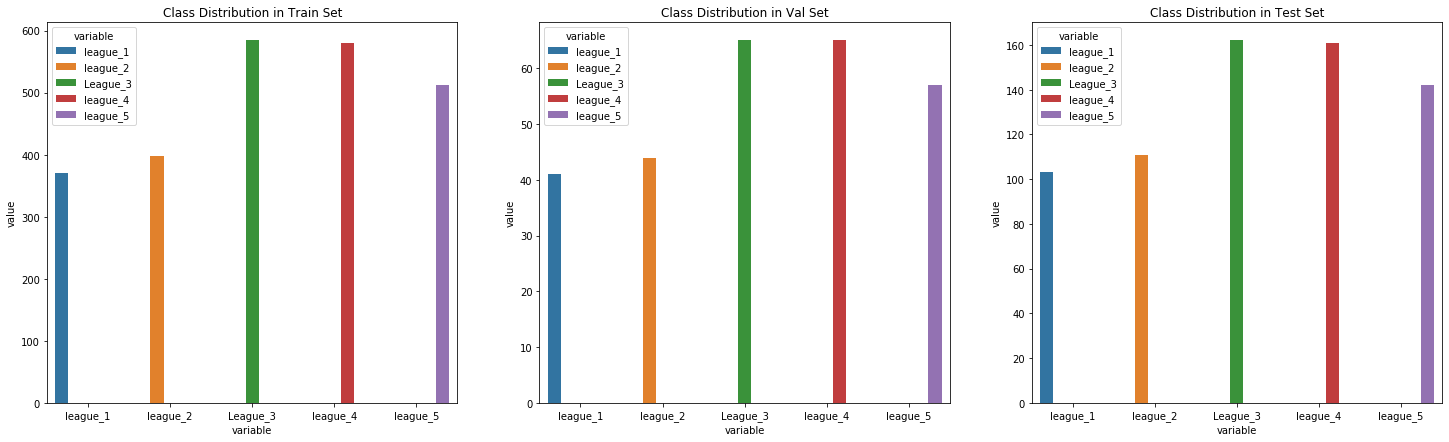

In [326]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(25,7))
sns.barplot(data = pd.DataFrame.from_dict([get_class_distribution(y_train)]).melt(), x = "variable", y="value", hue="variable",  ax=axes[0]).set_title('Class Distribution in Train Set')
sns.barplot(data = pd.DataFrame.from_dict([get_class_distribution(y_val)]).melt(), x = "variable", y="value", hue="variable",  ax=axes[1]).set_title('Class Distribution in Val Set')
sns.barplot(data = pd.DataFrame.from_dict([get_class_distribution(y_test)]).melt(), x = "variable", y="value", hue="variable",  ax=axes[2]).set_title('Class Distribution in Test Set')

Custom dataset

In [327]:
class ClassifierDataset(Dataset):
    
    def __init__(self, X_data, y_data):
        self.X_data = X_data
        self.y_data = y_data
        
    def __getitem__(self, index):
        return self.X_data[index], self.y_data[index]
        
    def __len__ (self):
        return len(self.X_data)


train_dataset = ClassifierDataset(torch.from_numpy(X_train).float(), torch.from_numpy(y_train).long())
val_dataset = ClassifierDataset(torch.from_numpy(X_val).float(), torch.from_numpy(y_val).long())
test_dataset = ClassifierDataset(torch.from_numpy(X_test).float(), torch.from_numpy(y_test).long())

In [328]:
target_list = []

for _, t in train_dataset:
    target_list.append(t)
    
target_list = torch.tensor(target_list)
target_list = target_list[torch.randperm(len(target_list))]

In [329]:
class_count = [i for i in get_class_distribution(y_train).values()]
class_weights = 1./torch.tensor(class_count, dtype=torch.float) 
class_weights

tensor([0.0027, 0.0025, 0.0017, 0.0017, 0.0020])

In [330]:
class_weights_all = class_weights[target_list]

In [331]:
weighted_sampler = WeightedRandomSampler(
    weights=class_weights_all,
    num_samples=len(class_weights_all),
    replacement=True
)

The model

In [332]:
EPOCHS = 300
BATCH_SIZE = 16
LEARNING_RATE = 0.0007

NUM_FEATURES = len(X_torch.columns)
NUM_CLASSES = 5

In [333]:
train_loader = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, sampler=weighted_sampler)
val_loader = DataLoader(dataset=val_dataset, batch_size=1)
test_loader = DataLoader(dataset=test_dataset, batch_size=1)

In [334]:
class MulticlassClassification(nn.Module):
    def __init__(self, num_feature, num_class):
        super(MulticlassClassification, self).__init__()
        
        self.layer_1 = nn.Linear(num_feature, 512)
        self.layer_2 = nn.Linear(512, 128)
        self.layer_3 = nn.Linear(128, 64)
        self.layer_out = nn.Linear(64, num_class) 
        
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=0.2)
        self.batchnorm1 = nn.BatchNorm1d(512)
        self.batchnorm2 = nn.BatchNorm1d(128)
        self.batchnorm3 = nn.BatchNorm1d(64)
        
    def forward(self, x):
        x = self.layer_1(x)
        x = self.batchnorm1(x)
        x = self.relu(x)
        
        x = self.layer_2(x)
        x = self.batchnorm2(x)
        x = self.relu(x)
        x = self.dropout(x)
        
        x = self.layer_3(x)
        x = self.batchnorm3(x)
        x = self.relu(x)
        x = self.dropout(x)
        
        x = self.layer_out(x)
        
        return x

In [336]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [337]:
model = MulticlassClassification(num_feature = NUM_FEATURES, num_class=NUM_CLASSES)
model.to(device)

print(model)

criterion = nn.CrossEntropyLoss(weight=class_weights.to(device))
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

MulticlassClassification(
  (layer_1): Linear(in_features=15, out_features=512, bias=True)
  (layer_2): Linear(in_features=512, out_features=128, bias=True)
  (layer_3): Linear(in_features=128, out_features=64, bias=True)
  (layer_out): Linear(in_features=64, out_features=5, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.2, inplace=False)
  (batchnorm1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm3): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)


In [338]:
def multi_acc(y_pred, y_test):
    y_pred_softmax = torch.log_softmax(y_pred, dim = 1)
    _, y_pred_tags = torch.max(y_pred_softmax, dim = 1)    
    
    correct_pred = (y_pred_tags == y_test).float()
    acc = correct_pred.sum() / len(correct_pred)
    
    acc = torch.round(acc) * 100
    
    return acc

In [339]:
accuracy_stats = {
    'train': [],
    "val": []
}

loss_stats = {
    'train': [],
    "val": []
}

In [341]:
from tqdm.notebook import tqdm

The training

In [342]:
print("Begin training.")

for e in tqdm(range(1, EPOCHS+1)):
    
    # TRAINING
    train_epoch_loss = 0
    train_epoch_acc = 0

    model.train()
    for X_train_batch, y_train_batch in train_loader:
        X_train_batch, y_train_batch = X_train_batch.to(device), y_train_batch.to(device)
        optimizer.zero_grad()
        
        y_train_pred = model(X_train_batch)
        
        train_loss = criterion(y_train_pred, y_train_batch)
        train_acc = multi_acc(y_train_pred, y_train_batch)
        
        train_loss.backward()
        optimizer.step()
        
        train_epoch_loss += train_loss.item()
        train_epoch_acc += train_acc.item()
        
        
    # VALIDATION    
    with torch.no_grad():
        
        val_epoch_loss = 0
        val_epoch_acc = 0
        
        model.eval()
        for X_val_batch, y_val_batch in val_loader:
            X_val_batch, y_val_batch = X_val_batch.to(device), y_val_batch.to(device)
            
            y_val_pred = model(X_val_batch)
                        
            val_loss = criterion(y_val_pred, y_val_batch)
            val_acc = multi_acc(y_val_pred, y_val_batch)
            
            val_epoch_loss += val_loss.item()
            val_epoch_acc += val_acc.item()

    
        
    loss_stats['train'].append(train_epoch_loss/len(train_loader))
    loss_stats['val'].append(val_epoch_loss/len(val_loader))
    accuracy_stats['train'].append(train_epoch_acc/len(train_loader))
    accuracy_stats['val'].append(val_epoch_acc/len(val_loader))
                              
    
    print(f'Epoch {e+0:03}: | Train Loss: {train_epoch_loss/len(train_loader):.5f} | Val Loss: {val_epoch_loss/len(val_loader):.5f} | Train Acc: {train_epoch_acc/len(train_loader):.3f}| Val Acc: {val_epoch_acc/len(val_loader):.3f}')

Begin training.


Epoch 001: | Train Loss: 1.35776 | Val Loss: 1.26663 | Train Acc: 11.111| Val Acc: 43.015
Epoch 002: | Train Loss: 1.26369 | Val Loss: 1.25190 | Train Acc: 22.876| Val Acc: 41.176
Epoch 003: | Train Loss: 1.25008 | Val Loss: 1.24245 | Train Acc: 18.954| Val Acc: 42.647
Epoch 004: | Train Loss: 1.25517 | Val Loss: 1.24447 | Train Acc: 21.569| Val Acc: 39.706
Epoch 005: | Train Loss: 1.20791 | Val Loss: 1.23199 | Train Acc: 27.451| Val Acc: 41.544
Epoch 006: | Train Loss: 1.22545 | Val Loss: 1.24461 | Train Acc: 24.837| Val Acc: 36.397
Epoch 007: | Train Loss: 1.23119 | Val Loss: 1.23841 | Train Acc: 24.837| Val Acc: 42.647
Epoch 008: | Train Loss: 1.21625 | Val Loss: 1.22370 | Train Acc: 22.222| Val Acc: 43.750
Epoch 009: | Train Loss: 1.22403 | Val Loss: 1.25159 | Train Acc: 23.529| Val Acc: 43.015
Epoch 010: | Train Loss: 1.18608 | Val Loss: 1.23676 | Train Acc: 26.797| Val Acc: 41.544
Epoch 011: | Train Loss: 1.20272 | Val Loss: 1.21875 | Train Acc: 30.719| Val Acc: 41.176
Epoch 012:

Text(0.5, 1.0, 'Train-Val Loss/Epoch')

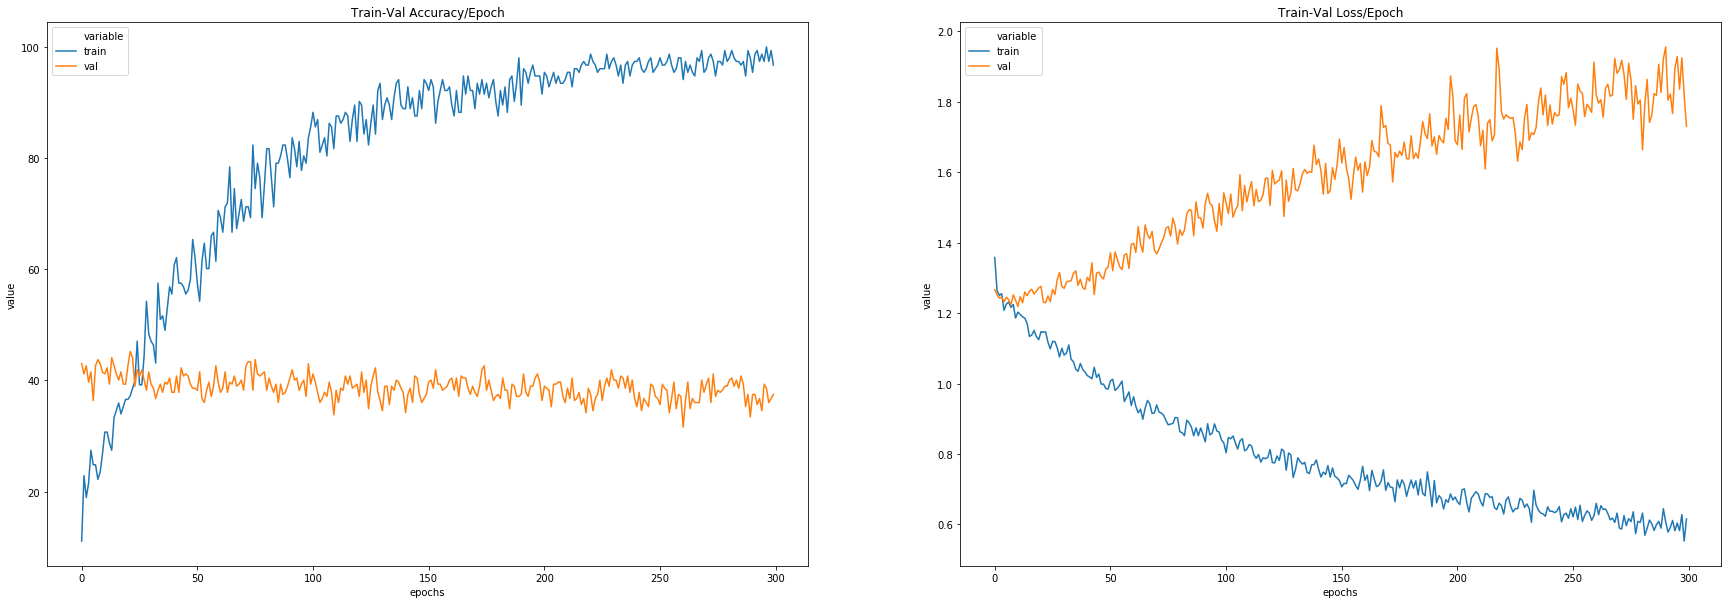

In [344]:
train_val_acc_df = pd.DataFrame.from_dict(accuracy_stats).reset_index().melt(id_vars=['index']).rename(columns={"index":"epochs"})
train_val_loss_df = pd.DataFrame.from_dict(loss_stats).reset_index().melt(id_vars=['index']).rename(columns={"index":"epochs"})

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(30,10))
sns.lineplot(data=train_val_acc_df, x = "epochs", y="value", hue="variable",  ax=axes[0]).set_title('Train-Val Accuracy/Epoch')
sns.lineplot(data=train_val_loss_df, x = "epochs", y="value", hue="variable", ax=axes[1]).set_title('Train-Val Loss/Epoch')

In [345]:
y_pred_list = []

with torch.no_grad():
    model.eval()
    for X_batch, _ in test_loader:
        X_batch = X_batch.to(device)
        y_test_pred = model(X_batch)
        y_pred_softmax = torch.log_softmax(y_test_pred, dim = 1)
        _, y_pred_tags = torch.max(y_pred_softmax, dim = 1)
        y_pred_list.append(y_pred_tags.cpu().numpy())

In [346]:
y_pred_list = [a.squeeze().tolist() for a in y_pred_list]

In [353]:
from sklearn.metrics import confusion_matrix, classification_report

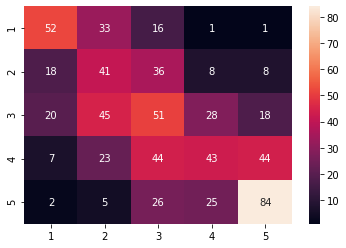

In [354]:
confusion_matrix_df = pd.DataFrame(confusion_matrix(y_test, y_pred_list)).rename(columns=idx2class, index=idx2class)
sns.heatmap(confusion_matrix_df, annot=True)

In [355]:
print(classification_report(y_test, y_pred_list))

              precision    recall  f1-score   support

           0       0.53      0.50      0.51       103
           1       0.28      0.37      0.32       111
           2       0.29      0.31      0.30       162
           3       0.41      0.27      0.32       161
           4       0.54      0.59      0.57       142

    accuracy                           0.40       679
   macro avg       0.41      0.41      0.41       679
weighted avg       0.41      0.40      0.40       679



All kinds of NN implementations did not show signifcant performance improvement either. Too bad. Makes me think taht there is simply not enough data (actually, this idea I had in mind from the very beginning...)

Let's try removing outliers explicitely

In [356]:
from scipy import stats

In [357]:
sc_rem_out = sc.copy()

In [359]:
sc.shape

(3395, 17)

In [358]:
sc_rem_out = sc_rem_out[(np.abs(stats.zscore(sc_rem_out)) < 3).all(axis=1)]

In [360]:
sc_rem_out.shape

(2859, 17)

In [366]:
sc_features = sc_rem_out.drop(['LeagueIndex', "GameID"], axis = 1)

In [367]:
sc_traget = sc_rem_out['LeagueIndex']

In [368]:
sc_norm_out = normalize_data(sc_features)

In [372]:
sc_train, sc_test, leagues_train, leagues_test = train_test_split(sc_norm_out, sc_traget, random_state=1,
                                                                  stratify = sc_traget)

print(f"Training dataset shape: {sc_train.shape}")
print(f"Test dataset shape: {sc_test.shape}")
print(f"Training target shape: {leagues_train.shape}")
print(f"Test target shape: {leagues_test.shape}")

Training dataset shape: (2144, 15)
Test dataset shape: (715, 15)
Training target shape: (2144,)
Test target shape: (715,)


In [375]:
def run_lr_pipe2(C):
    pipe_lr = Pipeline([('selector', SelectKBest()), 
                         ('lr', LogisticRegression(class_weight = 'balanced', multi_class = 'multinomial', solver = 'newton-cg'))])

    params_pipe_lr = {'selector__score_func': [f_classif, mutual_info_classif, chi2],
                       'selector__k': [3, 4, 5, 6, 7, 10, sc_norm_out.shape[1]],
                       'lr__C': C}
 
    gs_pipe_lr2 = GridSearchCV(estimator=pipe_lr, 
                               param_grid=params_pipe_lr, 
                               cv=cv,
                               n_jobs = -1,
                               scoring='accuracy',
                               verbose=0)

    gs_pipe_lr2.fit(sc_norm_out, sc_traget);
    
    return gs_pipe_lr2


gs_pipe_lr2 = run_lr_pipe2([0.001, 0.01, 1, 10])

In [376]:
gs_pipe_lr2.best_score_

0.42088839356790325

Our best model with outliers - the Logistic Regression, did not improve when the outliers were removed. We can try with other algorithms in the future....

But before that, let's get to the bruteforce! Meaning, let's generate lot's of features and see of it helps

In [396]:
import featuretools as ft

In [402]:
sc_features_ft = sc.drop(['GameID', "LeagueIndex"], axis = 1)
sc_target_ft = sc['LeagueIndex']

In [404]:
es = ft.EntitySet(id = 'sc')

In [410]:
sc_features_ft.drop(['index'], axis = 1, inplace = True)

In [411]:
es.entity_from_dataframe(entity_id = 'sc', dataframe = sc_features_ft, 
                         make_index = True, index = 'index')

Entityset: sc
  Entities:
    sc [Rows: 3395, Columns: 16]
  Relationships:
    No relationships

In [412]:
feature_matrix, feature_defs = ft.dfs(entityset = es, target_entity = 'sc', agg_primitives=["mean", "sum", "mode", "max", "min", "std", "skew"], 
                                      trans_primitives = ['add_numeric', 'multiply_numeric'])

In [413]:
feature_matrix.head()

APM  SelectByHotkeys  AssignToHotkeys  UniqueHotkeys  \
index                                                              
0      143.7180         0.003515         0.000220              7   
1      129.2322         0.003304         0.000259              4   
2       69.9612         0.001101         0.000336              4   
3      107.6016         0.001034         0.000213              1   
4      122.8908         0.001136         0.000327              2   

       MinimapAttacks  MinimapRightClicks  NumberOfPACs  GapBetweenPACs  \
index                                                                     
0            0.000110            0.000392      0.004849         32.6677   
1            0.000294            0.000432      0.004307         32.9194   
2            0.000294            0.000461      0.002926         44.6475   
3            0.000053            0.000543      0.003783         29.2203   
4            0.000000            0.001329      0.002368         22.6885   

       ActionLatency  ActionsInPAC  ...  \
index                               ...   
0            40.8673        4.7508  ...   
1            42.3454        4.8434  ...   
2            75.3548        4.0430  ...   
3            53.7352        4.9155  ...   
4            62.0813        9.3740  ...   

       GapBetweenPACs + WorkersMade * MinimapAttacks  \
index                                                  
0                                           0.003589   
1                                           0.009681   
2                                           0.013110   
3                                           0.001557   
4                                           0.000000   

       AssignToHotkeys + ComplexUnitsMade * AssignToHotkeys + MinimapRightClicks  \
index                                                                              
0                                           1.344580e-07                           
1                                           1.795210e-07                           
2                                           2.674429e-07                           
3                                           1.612135e-07                           
4                                           5.420138e-07                           

       ComplexAbilitiesUsed * MinimapRightClicks + WorkersMade  \
index                                                            
0                                           0.000000e+00         
1                                           3.374956e-07         
2                                           2.276369e-07         
3                                           3.719225e-07         
4                                           4.819388e-08         

       APM + MinimapRightClicks * NumberOfPACs + SelectByHotkeys  \
index                                                              
0                                               1.202089           
1                                               0.983574           
2                                               0.281725           
3                                               0.518222           
4                                               0.430652           

       ActionLatency + ActionsInPAC * TotalMapExplored + WorkersMade  \
index                                                                  
0                                            1277.370510               
1                                            1038.209920               
2                                            1746.810716               
3                                            1114.388297               
4                                            1071.913424               

       APM + MinimapRightClicks * GapBetweenPACs + MinimapRightClicks  \
index                                                                   
0                                            4695.005708                
1                                            4254.316605     

In [414]:
sc_train_ft, sc_test_ft, leagues_train_ft, leagues_test_ft = train_test_split(feature_matrix, sc_target_ft, random_state=1,
                                                                  stratify = sc_target_ft)

print(f"Training dataset shape: {sc_train_ft.shape}")
print(f"Test dataset shape: {sc_test_ft.shape}")
print(f"Training target shape: {leagues_train_ft.shape}")
print(f"Test target shape: {leagues_test_ft.shape}")

Training dataset shape: (2546, 7260)
Test dataset shape: (849, 7260)
Training target shape: (2546,)
Test target shape: (849,)


In [416]:
def run_lr_pipe3(C):
    pipe_lr = Pipeline([('selector', SelectKBest()), 
                         ('lr', LogisticRegression(class_weight = 'balanced', multi_class = 'multinomial', solver = 'newton-cg'))])

    params_pipe_lr = {'selector__score_func': [f_classif, mutual_info_classif, chi2],
                       'selector__k': [3, 4, 5, 6, 7, 10, sc_norm_out.shape[1]],
                       'lr__C': C}
 
    gs_pipe_lr3 = GridSearchCV(estimator=pipe_lr, 
                               param_grid=params_pipe_lr, 
                               cv=cv,
                               n_jobs = -1,
                               scoring='accuracy',
                               verbose=0)

    gs_pipe_lr3.fit(sc_train_ft, leagues_train_ft);
    
    return gs_pipe_lr3


gs_pipe_lr3 = run_lr_pipe3([0.001, 0.01, 1, 10])
gs_pipe_lr3.best_score_

/Users/pavelgolubev/opt/anaconda3/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


0.4315271517906443

In [417]:
gs_pipe_lr3.best_params_

{'lr__C': 1,
 'selector__k': 15,
 'selector__score_func': <function sklearn.feature_selection._univariate_selection.f_classif(X, y)>}

Adding faetures made the model more stable, but the accuracy is still roughly the same. Expected.

# Stacking

Another way to try to improve our result is stacking. In the following cells we will test this hypothesis by stacking basic models and compare the stacked result with individual model outcome. Note: the hypothesis is tested at "one shot" - there is no CV for the sake of trying it out, we will use best parameteres we obtained on previous steps. However, the stacking will be cross validated.

In [438]:
from sklearn.ensemble import StackingClassifier

In [450]:
from numpy import mean, std

In [452]:
from matplotlib import pyplot

In [445]:
def get_stacking():
	# define the base models
    level0 = list()
    level0.append(('lr', LogisticRegression(class_weight = 'balanced', multi_class = 'multinomial', solver = 'newton-cg')))
    level0.append(('knn', KNeighborsClassifier()))
    level0.append(('cart', DecisionTreeClassifier(max_depth = 5, min_samples_split = 5)))
    level0.append(('svm', SVC(class_weight='balanced', decision_function_shape = "ovo", C = 1)))
    level0.append(('bayes', GaussianNB(var_smoothing = 0.17886495290574334)))
    level0.append(('rfc', RandomForestClassifier(class_weight = 'balanced', oob_score = True, max_depth = 5, n_estimators = 1000)))
    level0.append(('cbc', CatBoostClassifier(**params_cbc )))
    level0.append(('lgbc', LGBMClassifier(objective = 'multiclass', boosting = 'dart', num_class = 5, class_weight = 'balanced')))
	# define meta learner model
    level1 = LogisticRegression()
	# define the stacking ensemble
    model = StackingClassifier(estimators=level0, final_estimator=level1, cv=5)
    return model

In [447]:
# get a list of models to evaluate
def get_models():
    models = dict()
    models['lr'] = LogisticRegression(class_weight = 'balanced', multi_class = 'multinomial', solver = 'newton-cg')
    models['knn'] = KNeighborsClassifier()
    models['cart'] = DecisionTreeClassifier(max_depth = 5, min_samples_split = 5)
    models['svm'] = SVC(class_weight='balanced', decision_function_shape = "ovo", C = 1)
    models['bayes'] = GaussianNB(var_smoothing = 0.17886495290574334)
    models['rfc'] = RandomForestClassifier(class_weight = 'balanced', oob_score = True, max_depth = 5, n_estimators = 1000)
    models['cbc'] = CatBoostClassifier(**params_cbc )
    models['lgbc'] = LGBMClassifier(objective = 'multiclass', boosting = 'dart', num_class = 5, class_weight = 'balanced')
    models['stacking'] = get_stacking()
    return models

In [448]:
# evaluate a give model using cross-validation
def evaluate_model(model):
	cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
	scores = cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')
	return scores

>lr 0.421 (0.039)
>knn 0.372 (0.030)
>cart 0.392 (0.043)
>svm 0.426 (0.033)
>bayes 0.403 (0.028)
>rfc 0.418 (0.042)
>cbc 0.420 (0.027)
>lgbc 0.401 (0.030)
>stacking 0.422 (0.036)


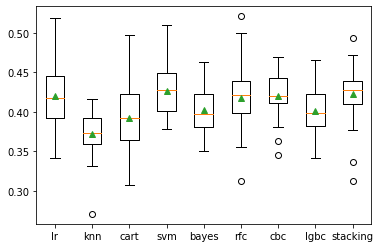

In [453]:
# define dataset
X, y = sc_train, leagues_train
# get the models to evaluate
models = get_models()
# evaluate the models and store results
results, names = list(), list()
for name, model in models.items():
	scores = evaluate_model(model)
	results.append(scores)
	names.append(name)
	print('>%s %.3f (%.3f)' % (name, mean(scores), std(scores)))
# plot model performance for comparison
pyplot.boxplot(results, labels=names, showmeans=True)
pyplot.show()

# Conclusion

Our dataset currently only has 3395 rows of data, which was when it was collected, a very small proportion of the existing player base. This also resulted in the imbalance in the spread of leagues in the data that caused us to merge several leagues together. Additionally, these are gathered from voluntarily submitted replays, which could make the model biased towards being accurate in predicting placements for active members of the community, who likely have more strategic knowledge, rather than the general population. These could possibly be solved by increasing the number of submitted replays from the community. Professional replays can be obtained when tournaments release their replay packs. We can also try to work with the developer Blizzard Entertainment to allow all players to opt in to automatic replay submissions for analysis after a ladder match.

The features found in the data alone are likely not sufficient to very accurately predict a player's league placement. Even adding "stupid" artificial features in "galore!" mode did not help. Features are very focused on the physical interactions the player has with the game, on top of that, there is a fair bit of overlap between the leagues. A core aspect of the game is resource management for which there is a very clear difference between skilled and unskilled players as well. Additional features such as average income, average savings, spending habits (such as use of production queueing) and production building activity counters could help paint a more well rounded picture of the players in game.

When creating the models, we chose to use pipelines to try multiple feature selectors and many hyperparameter combinations, and then refining the model after. While it seems to have been effective to a degree, we could potentially improve our predictive power by using in depth analysis to manually select features and hyperparameter values. 
Neural nets and stacking did not show any significant performance improvement, thus returning us to the issue of the lack of data.
Still, we consider the result of the project as positve, as it is obviously better, than random palcement being in palce so far :)